This notebook explores how different missing data patterns and imputation methods influence both predictive performance and fairness across demographic groups. The [Adult Income Dataset](https://www.kaggle.com/datasets/wenruliu/adult-income-dataset), the [COMPAS Recidivism Racial Bias Dataset](https://github.com/propublica/compas-analysis/tree/master) and the [German Credit Risk Dataset](https://www.kaggle.com/datasets/kabure/german-credit-data-with-risk/data) will be used for this analysis.

For more details on the work, read the [report](IAS_Individual_Assignment_Report.pdf)!

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.calibration import calibration_curve
import xgboost as xgb
from xgboost import XGBClassifier
from scipy.stats import ttest_rel
import math

# Clean and Load Adult Income Dataset
When cleaning the Adult Income Dataset, make sure to replace "?" with NaN values to properly identify missing values. Also, drop unnecessary columns such as "fnlwgt" (final weight) and "educational-num" (redundant with "education"). Finally, standardise the target variable "income" to be binary (0: <=50K, 1: >50K) and rename it to "target" for easier reference later.

In [2]:
# Load Adult Income Dataset
df_adult = pd.read_csv("data/adult.csv")

# Replace "?" with NaN
df_adult.replace("?", np.nan, inplace=True)

# Drop existing missing values for "Perfect" baseline
df_adult.dropna(inplace=True)

# Remove unnecessary columns, such as "fnlwgt" (final weight) and "educational-num" (redundant with "education")
df_adult.drop(columns=["fnlwgt", "educational-num"], inplace=True)

# Standardise target variable (income -> 0: <=50K, 1: >50K)
df_adult["income"] = df_adult["income"].apply(lambda x: 0 if x == "<=50K" else 1)

# Store the target variable ("income") in a new column "target" for easier reference later
df_adult.rename(columns={"income": "target"}, inplace=True)

print(f"Dataset has {len(df_adult)} rows")
print(df_adult.isnull().sum())

Dataset has 45222 rows
age               0
workclass         0
education         0
marital-status    0
occupation        0
relationship      0
race              0
gender            0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
target            0
dtype: int64


# Clean and Load COMPAS Dataset
When cleaning the COMPAS Dataset, filter the rows based on [ProPublica"s logic](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) to ensure consistency. Also, this study will focus only on two racial groups: "African-American" and "Caucasian". Make sure to drop unnecessary columns to simplify the analysis. Finally, rename the target variable "two_year_recid" to "target" for easier reference later.

In [3]:
# Load COMPAS Dataset
df_compas = pd.read_csv("data/compas-scores-two-years.csv")

# Filter rows, following ProPublica"s logic (available at their GitHub (where the dataset is hosted) and https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm)
df_compas = df_compas[
    (df_compas["days_b_screening_arrest"] <= 30) &
    (df_compas["days_b_screening_arrest"] >= -30) &
    (df_compas["is_recid"] != -1) &
    (df_compas["c_charge_degree"] != "O") &
    (df_compas["score_text"] != "N/A")
]

# Filter Race to only account for 2 groups: African-American and Caucasian
df_compas = df_compas[df_compas["race"].isin(["African-American", "Caucasian"])]

# Remove unnecessary columns
"""
I will keep only the following columns:
- two_year_recid (target variable)
- age
- c_charge_degree (current charge degree: Misdemeanor or Felony)
- race (sensitive attribute)
- sex (also a sensitive attribute)
- priors_count (number of prior offenses)
- juv_fel_count (number of juvenile felony offenses)
- juv_misd_count (number of juvenile misdemeanor offenses)
- juv_other_count (number of other juvenile offenses)
All other columns will be dropped to simplify the analysis.
"""
columns_to_keep = [
    "two_year_recid",
    "age",
    "c_charge_degree",
    "race",
    "sex",
    "priors_count",
    "juv_fel_count",
    "juv_misd_count",
    "juv_other_count",
]
df_compas = df_compas[columns_to_keep]

# Store the target variable ("two_year_recid") in a new column "target" for easier reference later
df_compas.rename(columns={"two_year_recid": "target"}, inplace=True)

print(f"Dataset has {len(df_compas)} rows")
print(df_compas.isnull().sum())

Dataset has 5278 rows
target             0
age                0
c_charge_degree    0
race               0
sex                0
priors_count       0
juv_fel_count      0
juv_misd_count     0
juv_other_count    0
dtype: int64


# Clean and Load German Credit Dataset
When cleaning the German Credit Dataset, remove the unnecessary index column. Handle missing values in "Saving accounts" and "Checking account" by replacing NaN with "no_account" to reflect the distinction between not having an account and not having the information. Standardise the target variable "Risk" to be binary (0: bad, 1: good) and rename it to "target" for easier reference later.

In [4]:
    # Load German Credit Dataset
df_german = pd.read_csv("data/german_credit_data.csv")

# Drop index column
df_german.drop(columns=["Unnamed: 0"], inplace=True)

# Handle missing values
# In this dataset, NaN values in "Saving accounts" and "Checking account" indicate that no account exists, which is different from not having the information.
# Therefore, I will replace NaN with "no_account" to reflect this distinction.
df_german["Saving accounts"] = df_german["Saving accounts"].fillna("no_account")
df_german["Checking account"] = df_german["Checking account"].fillna("no_account")

# Standardise target variable (Risk -> 0: bad, 1: good)
df_german["Risk"] = df_german["Risk"].apply(lambda x: 0 if x == "bad" else 1)

# Store the target variable ("Risk") in a new column "target" for easier reference later
df_german.rename(columns={"Risk": "target"}, inplace=True)

print(f"Dataset has {len(df_german)} rows")

print(df_german.isnull().sum())

Dataset has 1000 rows
Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
target              0
dtype: int64


# Function for Targeted EDA
This function creates three plots side by side for a given dataset:
- Target Distribution (0 vs 1)
- Sensitive Group Distribution
- Target Probability by Sensitive Group

With this function, the baseline fairness of each dataset can be assessed before proceeding with further analysis.

In [5]:
def run_targeted_eda(df, sensitive_column, dataset_name, outcome_label):
    print(f"Analysing {dataset_name}")

    # Create a 1x3 grid of plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    total_count = len(df)

    def add_percentage_labels(ax, total):
        for p in ax.patches:
            height = p.get_height()

            if total > 0:
                pct = 100 * height / total
                ax.annotate(f"{int(height)}\n({pct:.1f}%)",
                            (p.get_x() + p.get_width() / 2., height),
                            ha="center", va="bottom", fontsize=10, color="black", xytext=(0, 5),
                            textcoords="offset points")

    # First plot: Target Distribution
    sns.countplot(x="target", data=df, ax=axes[0], palette="viridis", hue="target", legend=False)
    axes[0].set_title(f"Target Distribution (0 vs 1)")
    axes[0].set_ylim(0, df["target"].value_counts().max() * 1.15)
    add_percentage_labels(axes[0], total_count)

    # Second plot: Sensitive Group Distribution
    sns.countplot(x=sensitive_column, data=df, ax=axes[1], palette="magma", hue=sensitive_column, legend=False)
    axes[1].set_title(f"Sensitive Group Size: {sensitive_column.capitalize()}")
    axes[1].set_ylim(0, df[sensitive_column].value_counts().max() * 1.15)
    add_percentage_labels(axes[1], total_count)

    # Third plot: Target Probability by Sensitive Group
    sns.barplot(x=sensitive_column, y="target", data=df, errorbar=None, ax=axes[2], palette="coolwarm", hue=sensitive_column, legend=False)

    for p in axes[2].patches:
        height = p.get_height()
        axes[2].annotate(f"{height:.2f}",
                        (p.get_x() + p.get_width() / 2., height),
                        ha="center", va="bottom", fontsize=10, xytext=(0, 5),
                        textcoords="offset points")

    axes[2].set_title(f"{outcome_label} Probability by {sensitive_column.capitalize()}")
    axes[2].set_ylabel("Probability (Mean Target)")
    axes[2].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.show()

    # Get baseline fairness statistics
    # Get the average value of the target variable for each sensitive group
    group_means = df.groupby(sensitive_column)["target"].mean()
    print(f"Probability of Positive Class per sensitive group:")
    for gender, percentage in group_means.items():
        print(f"{gender}: {(percentage * 100):.2f}%")

    # Calculate the gap between both groups (closer to 0 is better)
    gap = (group_means.max() - group_means.min()).round(2)
    baseline_bias = "The data is already biased" if gap > 0.10 else "The data is relatively balanced"
    print(f"Gap between groups: {gap} -> {baseline_bias}\n")

Analysing Adult Income


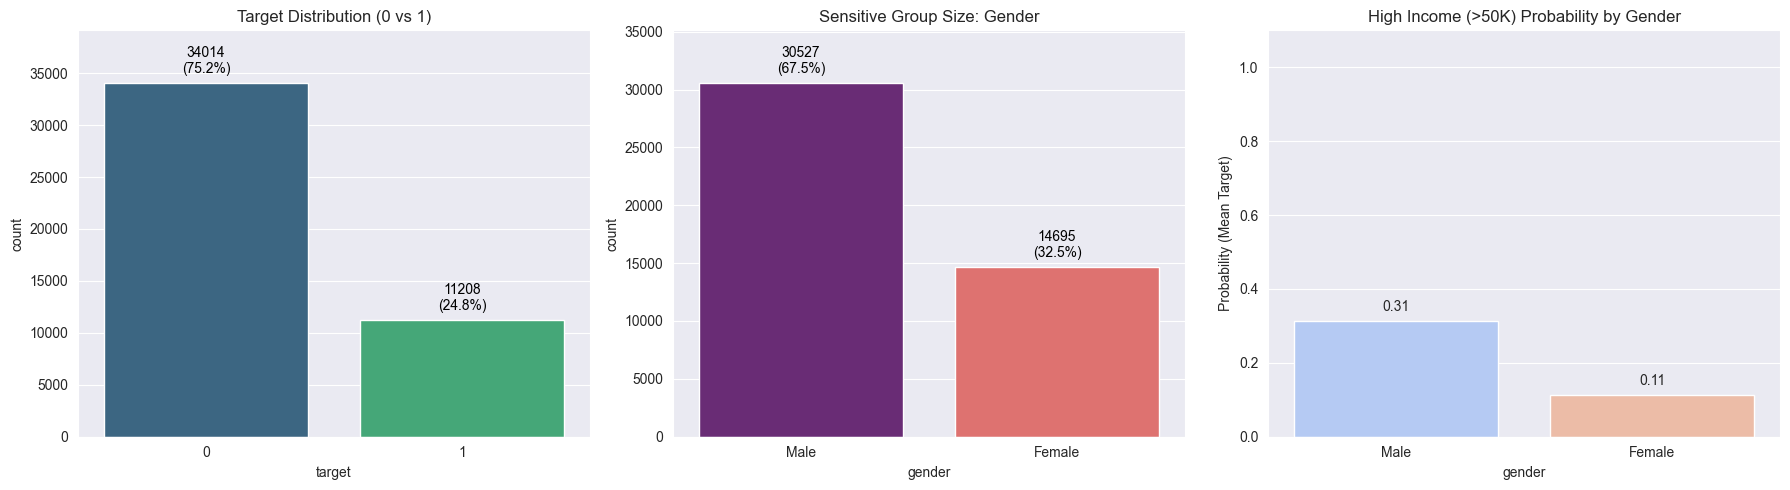

Probability of Positive Class per sensitive group:
Female: 11.36%
Male: 31.25%
Gap between groups: 0.2 -> The data is already biased

Analysing COMPAS Recidivism


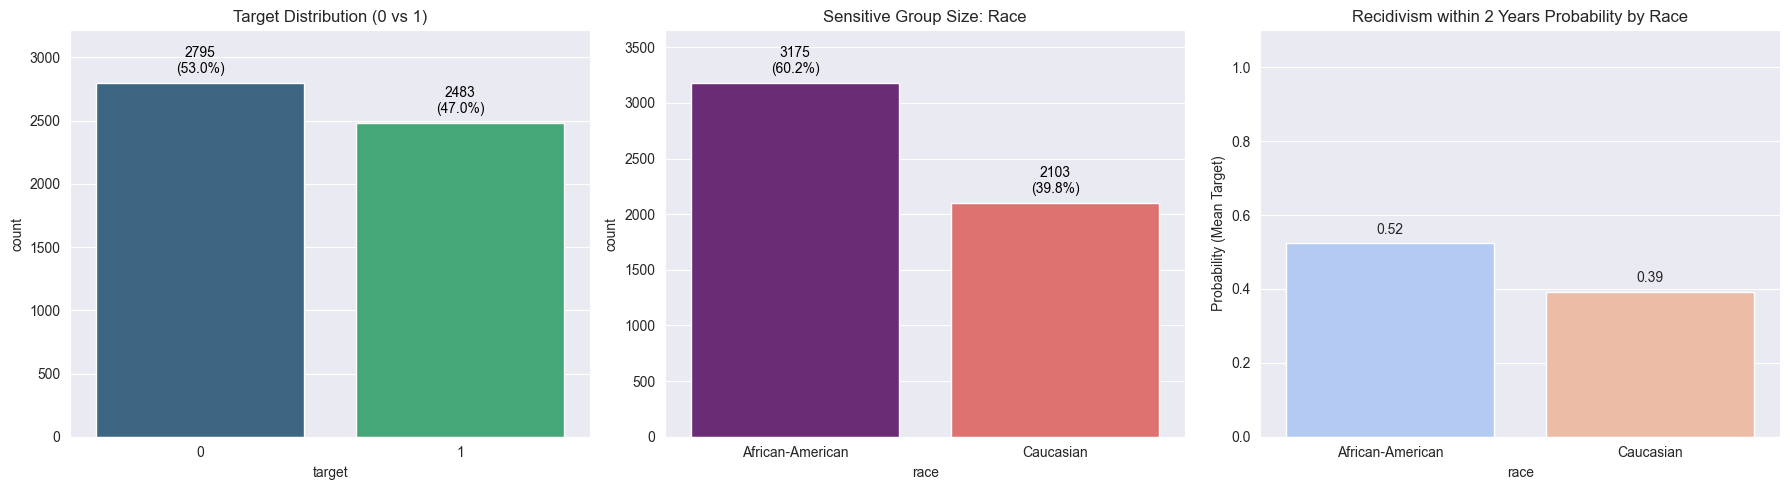

Probability of Positive Class per sensitive group:
African-American: 52.31%
Caucasian: 39.09%
Gap between groups: 0.13 -> The data is already biased

Analysing German Credit


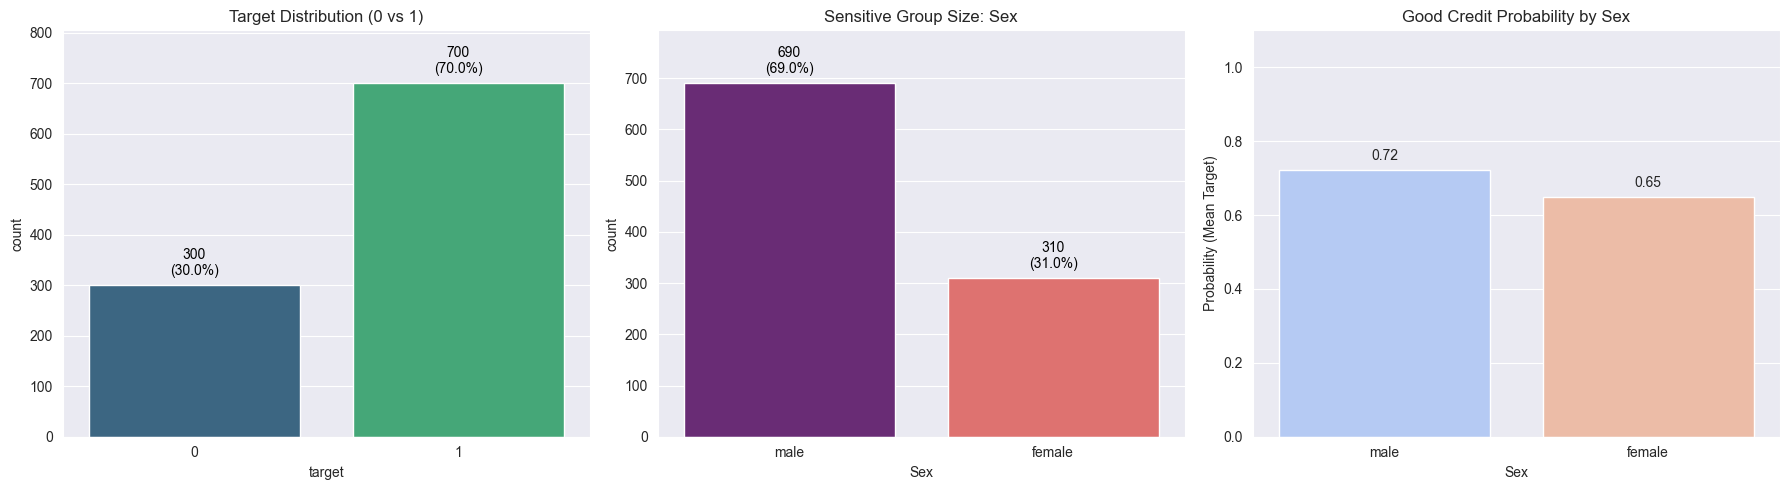

Probability of Positive Class per sensitive group:
female: 64.84%
male: 72.32%
Gap between groups: 0.07 -> The data is relatively balanced



In [6]:
# 1. Adult Income (Sensitive: Sex or Race)
run_targeted_eda(df_adult, sensitive_column="gender", dataset_name="Adult Income", outcome_label="High Income (>50K)")

# 2. COMPAS (Sensitive: Race)
run_targeted_eda(df_compas, sensitive_column="race", dataset_name="COMPAS Recidivism", outcome_label="Recidivism within 2 Years")

# 3. German Credit (Sensitive: Sex)
run_targeted_eda(df_german, sensitive_column="Sex", dataset_name="German Credit", outcome_label="Good Credit")

# Ordinal Encoding Pre-Split
This function encodes the categorical columns of the dataset, converting strings into integer representations. This transformation is necessary for imputation algorithms such as KNN (distance-based) and MICE (regression-based), which need numerical input vectors to compute missing values.
The sensitive column follows a simple label encoding, converting categories into integers based on alphanumerical order. For the sensitive attributes in all of the datasets that were analysed, it resulted in the unprivileged group being mapped to 0 and the privileged group to 1.

In [7]:
def pre_split_encoding(df, target_column, sensitive_column, dataset_name):
    print(f"Ordinal encoding for {dataset_name}")
    df_encoded = df.copy()

    # Extract categorical columns
    categorical_columns = df_encoded.select_dtypes(include=["object", "category"]).columns.tolist()

    # Exclude target and sensitive columns from encoding
    if target_column in categorical_columns: categorical_columns.remove(target_column)
    if sensitive_column in categorical_columns: categorical_columns.remove(sensitive_column)

    # Apply Ordinal Encoding
    ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    df_encoded[categorical_columns] = ordinal_encoder.fit_transform(df_encoded[categorical_columns])

    # Handle sensitive column (ensure 0 and 1 encoding) using label encoding
    sensitive_label_encoder = LabelEncoder()
    df_encoded[sensitive_column] = sensitive_label_encoder.fit_transform(df_encoded[sensitive_column])

    # Print the mapping for sensitive attribute
    mapping = dict(zip(sensitive_label_encoder.classes_, sensitive_label_encoder.transform(sensitive_label_encoder.classes_)))
    # Dictionary comprehension to display numpy.int64 values as native ints for readability
    print(f"Sensitive Attribute \"{sensitive_column}\" Mapping: { {k: int(v) for k, v in mapping.items()} }")

    # Return the encoded dataset
    return df_encoded

In [8]:
# 1. Adult Income
df_adult_encoded = pre_split_encoding(df_adult, target_column="target", sensitive_column="gender", dataset_name="Adult Income")

# 2. COMPAS
df_compas_encoded = pre_split_encoding(df_compas, target_column="target", sensitive_column="race", dataset_name="COMPAS Recidivism")

# 3. German Credit
df_german_encoded = pre_split_encoding(df_german, target_column="target", sensitive_column="Sex", dataset_name="German Credit")

Ordinal encoding for Adult Income
Sensitive Attribute "gender" Mapping: {'Female': 0, 'Male': 1}
Ordinal encoding for COMPAS Recidivism
Sensitive Attribute "race" Mapping: {'African-American': 0, 'Caucasian': 1}
Ordinal encoding for German Credit
Sensitive Attribute "Sex" Mapping: {'female': 0, 'male': 1}


# Correlation Matrices
This function computes the pairwise Pearson correlation coefficients between all numerical features of the given dataset. It is important to:
- **Detect multicollinearity**: Helps identify features that are highly correlated with each other;
- **Identify Proxies**: This is the most important aspect, as it can reveal possible proxy variables, for example, non-sensitive features that are strongly correlated with the sensitive attributes. For example, as observed in the Adult Income correlation matrix, "sex" and "relationship" are strongly correlated (although negatively, likely due to encoding), which is expected, since some "relationship" contains values that are directly associated with values of the "gender" column (i.e., Husband ("relationship") -> Male ("gender") and Wife ("relationship") -> Female ("gender"). This shows that "relationship" acts as a direct proxy for "gender", and simply removing the "gender" column would not be sufficient to make the model "blind" to this attribute. Although both features are kept, it is important to keep this in mind, since an approach like "Fairness Through Unawareness" would likely fail here, as the model could recover gender information by using the "relationship" column.

In [9]:
def plot_correlation_matrix(dataset, dataset_name):
    df_corr = dataset.copy()

    for col in df_corr.columns:
        # Check if column is Object (string) or Category
        if df_corr[col].dtype == "object" or df_corr[col].dtype.name == "category":
            # Factorize to have numerical values for the correlation calculation
            df_corr[col], _ = pd.factorize(df_corr[col])

    # Compute the correlation
    corr = df_corr.corr(method="spearman")

    plt.figure(figsize=(14, 12))
    # Show only one triangle as opposed to the entire square
    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(
        corr,
        mask=mask,
        cmap="coolwarm",
        center=0,
        vmax=1.0, vmin=-1.0,
        annot=True,
        fmt=".2f",
        square=True,
        linewidths=.5,
        cbar_kws={"shrink": .5},
        annot_kws={"size": 9}
    )

    plt.title(f"Feature Correlation: {dataset_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

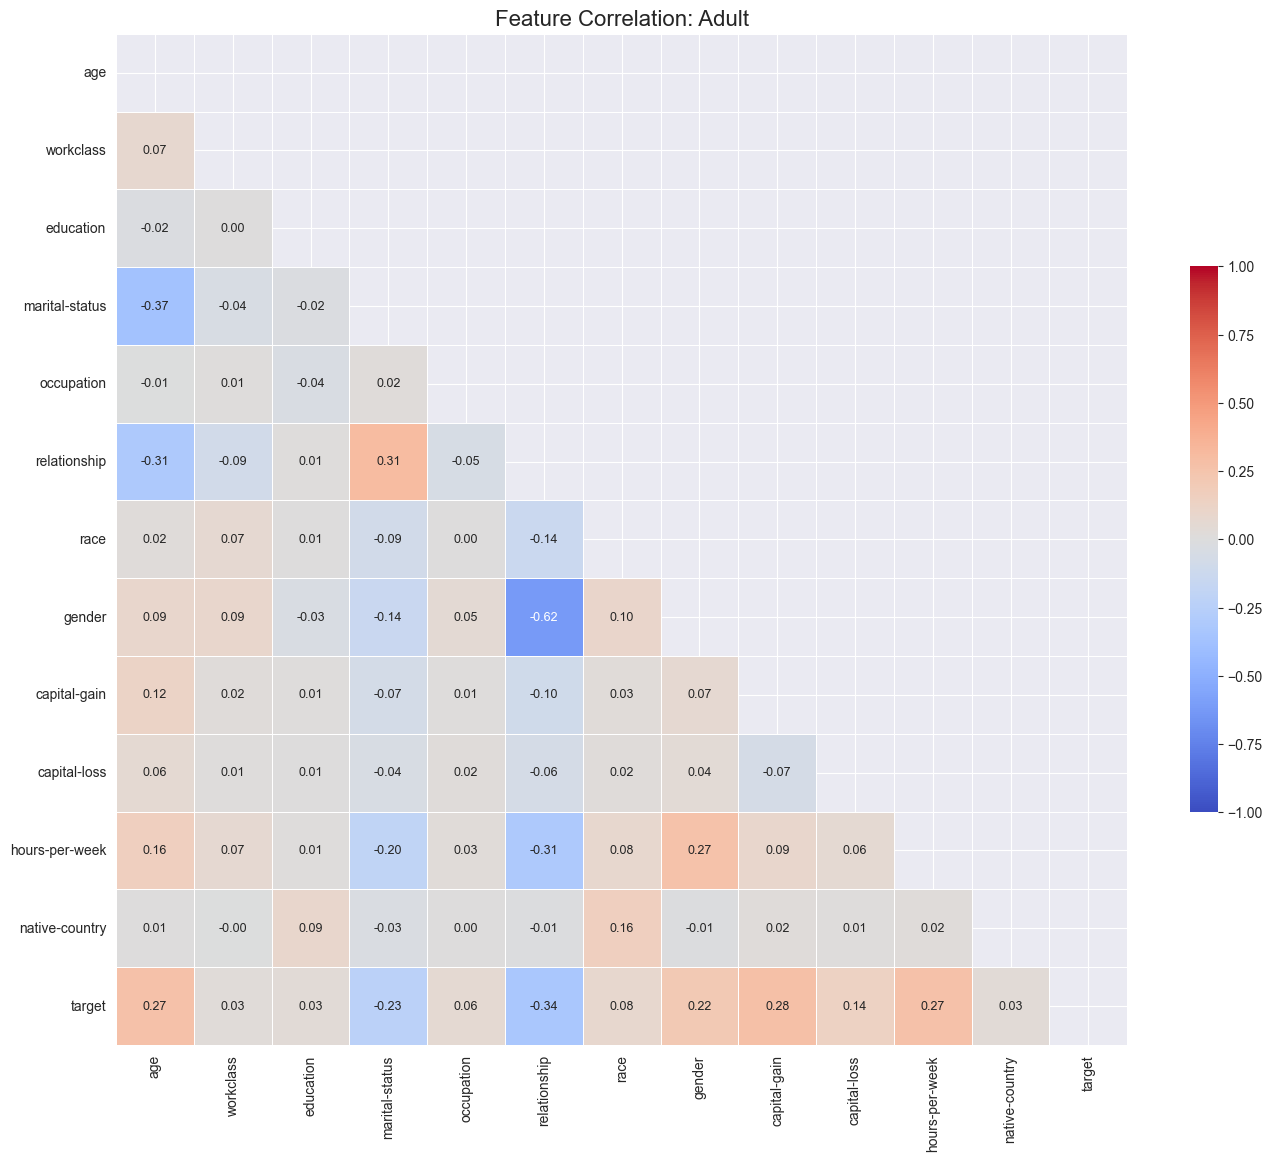

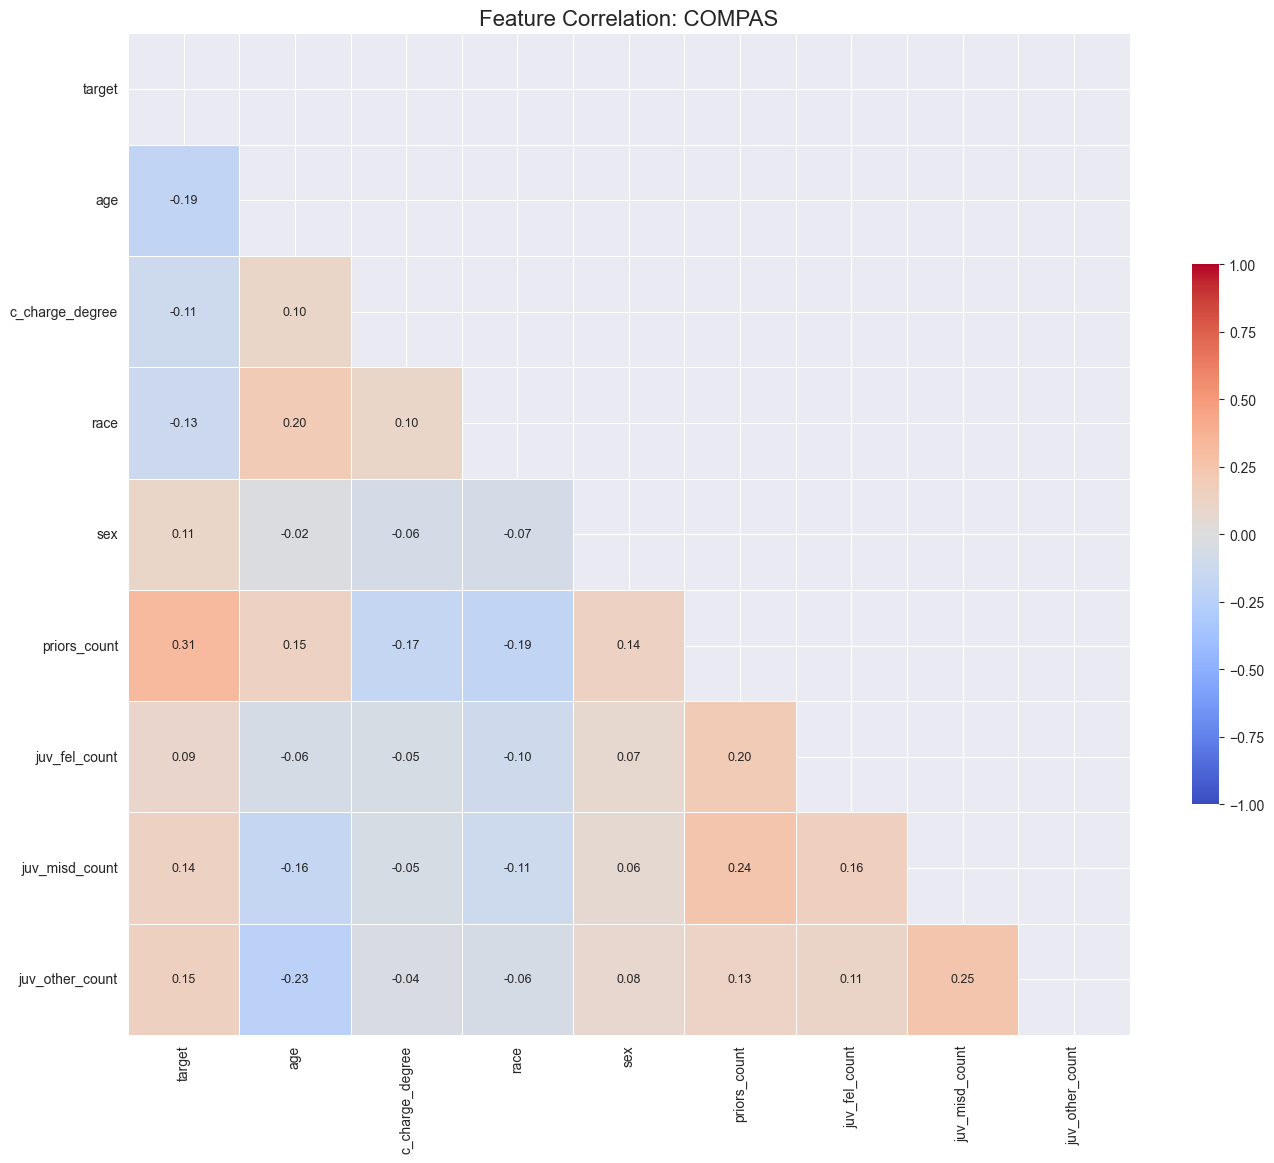

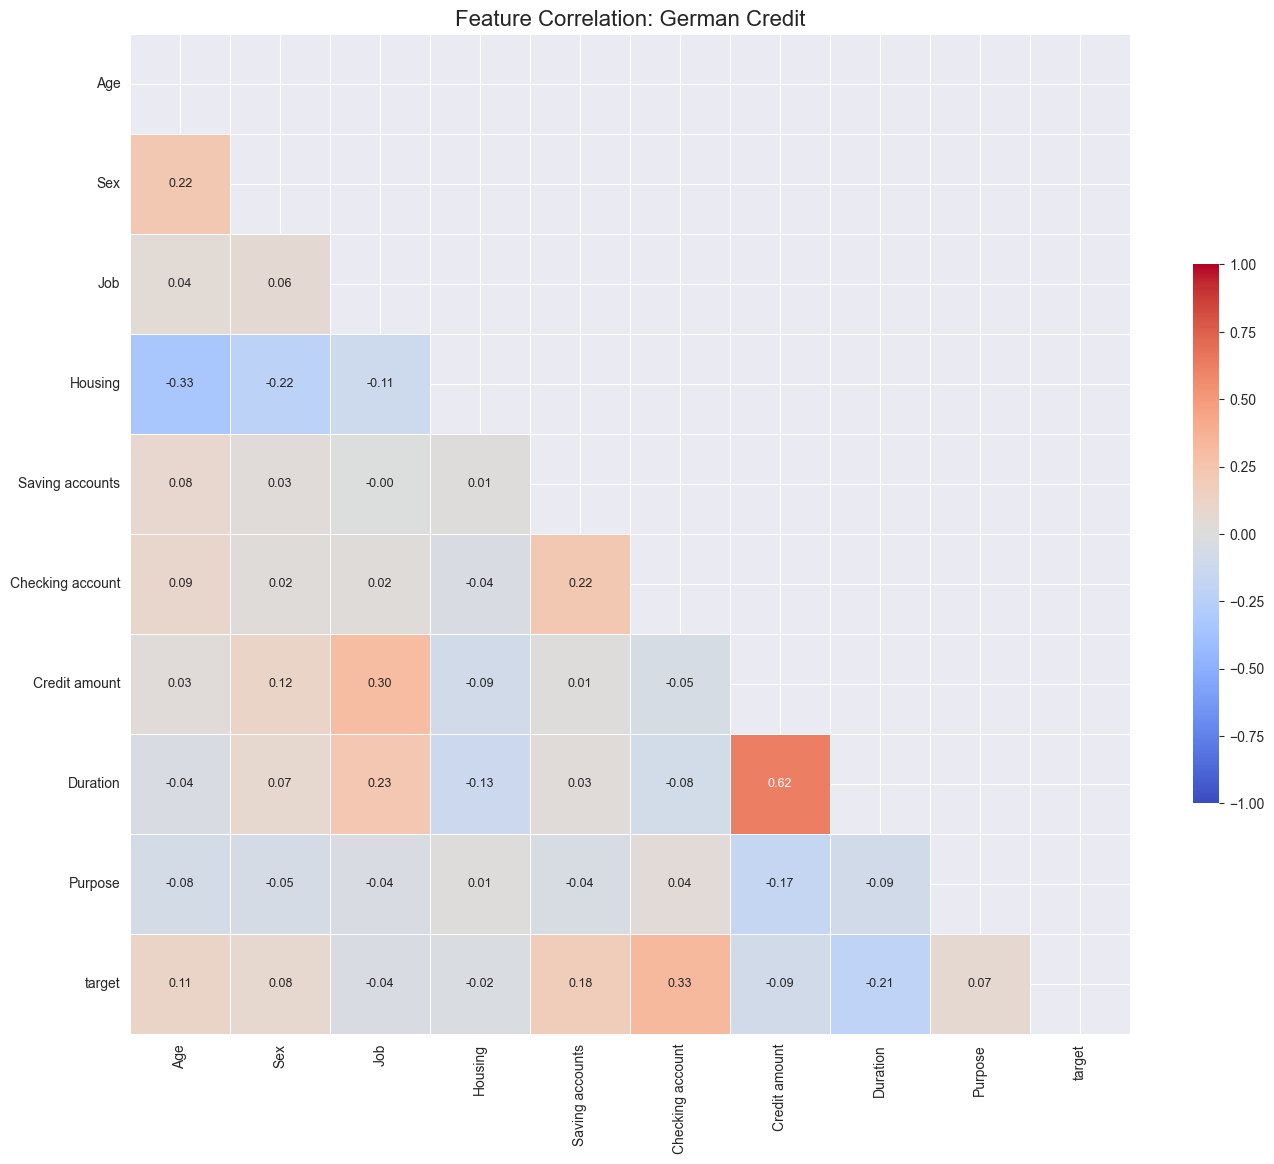

In [10]:
# 1. Adult Income
plot_correlation_matrix(df_adult_encoded, "Adult")

# 2. COMPAS
plot_correlation_matrix(df_compas_encoded, "COMPAS")

# 3. German Credit
plot_correlation_matrix(df_german_encoded, "German Credit")

# Train-Test Split (80-20 Stratified)
This function splits the data into train and test sets (80% train, 20% test), in a stratified manner. This ensures that the percentage of each of the classes is the same (or very close, if no perfect division is possible) in both train and test sets (i.e., both test and train sets have 70% of class 1 and 30% of class 0).

In [11]:
def stratified_train_test_split(df, target_column, dataset_name, random_state=42):
    print(f"Stratified splitting for {dataset_name}")

    # Separate target column from other columns
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Stratified Train-Test Split (80-20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        stratify=y,
        random_state=random_state
    )

    # Analyse overall distribution and sizes of train and test sets
    print(f"Train Shape: {X_train.shape} | Test Shape: {X_test.shape}")
    train_abs_val, train_rel_pct = y_train.value_counts().values, y_train.value_counts(normalize=True).values.round(4)
    test_abs_val, test_rel_pct = y_test.value_counts().values, y_test.value_counts(normalize=True).values.round(4)
    print(f"Train Target Counts: {train_abs_val} ({train_rel_pct*100})")
    print(f"Test Target Counts: {test_abs_val} ({test_rel_pct*100})")

    return X_train, X_test, y_train, y_test

In [12]:
# Dictionary to hold all datasets" splits
datasets_splits = {"Adult": {}, "COMPAS": {}, "German": {}}

# 1. Adult Income
datasets_splits["Adult"]["X_train"], datasets_splits["Adult"]["X_test"], datasets_splits["Adult"]["y_train"], datasets_splits["Adult"]["y_test"] = stratified_train_test_split(df_adult_encoded, target_column="target", dataset_name="Adult Income")

# 2. COMPAS
datasets_splits["COMPAS"]["X_train"], datasets_splits["COMPAS"]["X_test"], datasets_splits["COMPAS"]["y_train"], datasets_splits["COMPAS"]["y_test"] = stratified_train_test_split(df_compas_encoded, target_column="target", dataset_name="COMPAS Recidivism")

# 3. German Credit
datasets_splits["German"]["X_train"], datasets_splits["German"]["X_test"], datasets_splits["German"]["y_train"], datasets_splits["German"]["y_test"] = stratified_train_test_split(df_german_encoded, target_column="target", dataset_name="German Credit")

Stratified splitting for Adult Income
Train Shape: (36177, 12) | Test Shape: (9045, 12)
Train Target Counts: [27211  8966] ([75.22 24.78])
Test Target Counts: [6803 2242] ([75.21 24.79])
Stratified splitting for COMPAS Recidivism
Train Shape: (4222, 8) | Test Shape: (1056, 8)
Train Target Counts: [2236 1986] ([52.96 47.04])
Test Target Counts: [559 497] ([52.94 47.06])
Stratified splitting for German Credit
Train Shape: (800, 9) | Test Shape: (200, 9)
Train Target Counts: [560 240] ([70. 30.])
Test Target Counts: [140  60] ([70. 30.])


# Function to evaluate Fairness
Given the actual classes and the predictions made by the model, this function computes both the Demographic Parity and the Equal Opportunity. After, it calculates the gap between both sensitive groups. These results are added to the model metrics, so that the final model performance (combination of both numerical performance and fairness performance) can be assessed.

In [13]:
def get_fairness_metrics(y_true, y_pred, sensitive_features):
    df_eval = pd.DataFrame({"y_true": y_true, "y_pred": y_pred, "sensitive": sensitive_features})

    # Demographic Parity
    selection_rates = df_eval.groupby("sensitive")["y_pred"].mean()
    dp_gap = selection_rates.max() - selection_rates.min()

    # Equal Opportunity
    tpr_df = df_eval[df_eval["y_true"] == 1]
    tpr_rates = tpr_df.groupby("sensitive")["y_pred"].mean()
    eo_gap = tpr_rates.max() - tpr_rates.min()

    return {"DP Gap": dp_gap, "EO Gap": eo_gap}

# Function to Train Models & Evaluate Performance + Fairness
This function is abstracted to be reusable for different datasets, models, and configurations:
- It starts by choosing the model passed as an argument and an appropriate scaler - Both Logistic Regression and MLP need to have the values scaled. XGBoost doesn't use any scaling - although it doesn't hurt its performance, it would be a "waste" of computation to scale values when it isn't necessary, so its natural behaviour was preserved.
- Then, the values in numerical columns are scaled and the values in categorical columns are One-Hot Encoded.
- Both the preprocessing and the classifier are encapsulated into a single Pipeline object. This prevents data leakage by ensuring that all transformations (such as scaling and encoding) are learned exclusively from the training set and subsequently applied to transform the test set during inference.
- Finally, Performance metrics (F1 score, Accuracy) and Fairness metrics (as described on the get_fairness_metrics function) are stored, alongside the Selection Rate, which is the average class picked by the model across all predictions.
    - This added metric is helpful to later detect and exclude trivial models that predict the same class for nearly all instances (i.e., picking 1 for every test case). In the case of the German Credit Dataset, where 70% of the values are of class 1, a lazy model could achieve an accuracy of 70% by simply predicting class 1 for everyone. The Selection Rate in this case would be close to 1, and with it we can identify that the model failed to learn meaningful patterns.

In [14]:
def run_model(X_train, X_test, y_train, y_test, cat_columns, sensitive_column, experiment_name, model_type, random_state=42):
    print(f"\n Training {model_type.upper()}: {experiment_name}")

    # Choose the correct model and scaling method
    if model_type == "logistic":
        clf = LogisticRegression(max_iter=1000, random_state=random_state)
        scaler = StandardScaler()
    elif model_type == "mlp":
        clf = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, early_stopping=True, random_state=random_state)
        scaler = StandardScaler()
    elif model_type == "xgboost":
        clf = XGBClassifier(eval_metric="logloss", random_state=random_state)
        scaler = "passthrough"
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    # Select the numerical columns to be scaled
    num_columns = [c for c in X_train.columns if c not in cat_columns]

    # Scale numerical columns (except when model is XGBoost) and One-Hot Encode categorical ones
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", scaler, num_columns),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_columns)
        ]
    )

    # Create the pipeline with both the preprocessing and the model (classifier) to be used
    model = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", clf)
    ])

    # Train and evaluate the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    sensitive_test = X_test[sensitive_column]
    fairness = get_fairness_metrics(y_test, y_pred, sensitive_test)

    print(f"Performance: Accuracy={acc:.4f} | F1={f1:.4f}")
    print(f"Fairness:    DP Gap={fairness["DP Gap"]:.4f} | EO Gap={fairness["EO Gap"]:.4f}")

    # Return model metrics (Performance, Fairness and Selection Rate)
    return {
        "Accuracy": acc,
        "F1": f1,
        "DP Gap": fairness["DP Gap"],
        "EO Gap": fairness["EO Gap"],
        "Selection Rate": np.mean(y_pred)
    }

In [15]:
# Categorical columns of each dataset to feed to training loop
adult_categorical = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "native-country", "gender"]
compas_categorical = ["c_charge_degree", "sex", "race"]
german_categorical = ["Housing", "Saving accounts", "Checking account", "Purpose", "Sex"]

# Models that will be trained
models_to_run = ["logistic", "xgboost", "mlp"]

# List to store results of all trained models (baseline)
results = []

for dataset_name, data in datasets_splits.items():
    if dataset_name == "Adult":
        categorical_columns = adult_categorical
        sensitive_column = "gender"
    elif dataset_name == "COMPAS":
        categorical_columns = compas_categorical
        sensitive_column = "race"
    elif dataset_name == "German":
        categorical_columns = german_categorical
        sensitive_column = "Sex"
    else: continue

    for model_name in models_to_run:
        metrics = run_model(
            X_train=data["X_train"],
            X_test=data["X_test"],
            y_train=data["y_train"],
            y_test=data["y_test"],
            cat_columns=categorical_columns,
            sensitive_column=sensitive_column,
            experiment_name=f"{dataset_name} Baseline",
            model_type=model_name
        )

        # Store the Dataset, Missing Data Pattern (in this case none -> Baseline), Imputation Method (in this case none) and Model Name
        metrics.update({
            "Dataset": dataset_name,
            "Missing Pattern": "Baseline",
            "Imputation Method": "None",
            "Model": model_name
        })

        results.append(metrics)

# Print Results
print("Baseline Results:")
results_df = pd.DataFrame(results)
print(results_df)


 Training LOGISTIC: Adult Baseline
Performance: Accuracy=0.8456 | F1=0.6560
Fairness:    DP Gap=0.1831 | EO Gap=0.1435

 Training XGBOOST: Adult Baseline
Performance: Accuracy=0.8637 | F1=0.7031
Fairness:    DP Gap=0.1783 | EO Gap=0.0867

 Training MLP: Adult Baseline
Performance: Accuracy=0.8485 | F1=0.6755
Fairness:    DP Gap=0.1795 | EO Gap=0.0719

 Training LOGISTIC: COMPAS Baseline
Performance: Accuracy=0.6496 | F1=0.5987
Fairness:    DP Gap=0.2578 | EO Gap=0.2718

 Training XGBOOST: COMPAS Baseline
Performance: Accuracy=0.6487 | F1=0.5972
Fairness:    DP Gap=0.1934 | EO Gap=0.1883

 Training MLP: COMPAS Baseline
Performance: Accuracy=0.6525 | F1=0.6058
Fairness:    DP Gap=0.2329 | EO Gap=0.2366

 Training LOGISTIC: German Baseline
Performance: Accuracy=0.7350 | F1=0.8191
Fairness:    DP Gap=0.2357 | EO Gap=0.1850

 Training XGBOOST: German Baseline
Performance: Accuracy=0.7500 | F1=0.8252
Fairness:    DP Gap=0.1143 | EO Gap=0.0950

 Training MLP: German Baseline
Performance: Acc

# Function to Introduce a specific Missing Data Pattern on the Data
This functions allows to introduce a specific Missing Data Pattern on a chosen dataset. In this case, it will be used on both the training and test sets. This function is designed for 3 patterns: MCAR, MAR and Group-Based. The latter is a specific type of missing data relevant to this study, where the unprivileged group has a higher missing data rate than the privileged group. The random number generator (rng) is initialized at the beginning based on the random_state to ensure reproducibility, i.e., different runs will yield the same results.
- MCAR: On the chosen target_column, missing values will appear at a missing_rate rate.
- MAR: On the chosen target_column, the missing_rate increases as the values of the mar_cause_column increases, i.e., as age increases the probability of a missing value in target_column increases.
- Group-Based: On the chosen target_column, missing values will appear at 1.5 times more than the base missing rate for the unprivileged group and 0.5 times less than the base missing rate for the privileged group.

In [16]:
def introduce_missingness(df, target_column, pattern_type, missing_rate, sensitive_column, mar_cause_column=None, random_state=42):
    df_missing = df.copy()
    n = len(df)

    # Initialize rng to ensure reproducibility
    rng = np.random.default_rng(random_state)

    # MCAR logic
    if pattern_type == "MCAR":
        n_missing = int(n * missing_rate)
        missing_indices = rng.choice(df.index, size=n_missing, replace=False)
        df_missing.loc[missing_indices, target_column] = np.nan

    # MAR logic
    elif pattern_type == "MAR":
        # Get the percentiles of scores
        percentiles = df[mar_cause_column].rank(pct=True)

        # Get the weights (to later give more probability/weight to values on higher percentiles)
        weights = percentiles ** 2
        weights = weights / weights.sum()

        n_missing = int(n * missing_rate)
        missing_indices = rng.choice(df.index, size=n_missing, replace=False, p=weights)
        df_missing.loc[missing_indices, target_column] = np.nan

    # Group-Based logic
    elif pattern_type == "Group":
        # Unprivileged has a higher missing rate, Privileged has lower missing rate
        unprivileged = missing_rate * 1.5
        r1 = missing_rate * 0.5

        # Get indices of Unprivileged group
        unprivileged_indices = df[df[sensitive_column] == 0].index
        n_missing_unprivileged = int(len(unprivileged_indices) * unprivileged)

        # Introduce missing data on unprivileged group
        missing_unprivileged_indices = rng.choice(unprivileged_indices, size=n_missing_unprivileged, replace=False)
        df_missing.loc[missing_unprivileged_indices, target_column] = np.nan

        # Get indices of Privileged group
        privileged_indices = df[df[sensitive_column] == 1].index
        n_missing_privileged = int(len(privileged_indices) * r1)

        # Introduce missing data on privileged group
        missing_privileged_indices = rng.choice(privileged_indices, size=n_missing_privileged, replace=False)
        df_missing.loc[missing_privileged_indices, target_column] = np.nan

    return df_missing

In [17]:
"""
Dictionary that for each dataset stores:
- The column where missing data will be introduced (target)
- The sensitive column (sensitive_column)
- The column where MAR will be based on (mar_cause)
"""
configs = {
    "Adult": {
        "target": "education",
        "sensitive_column": "gender",
        "mar_cause": "age"
    },
    "COMPAS": {
        "target": "priors_count",
        "sensitive_column": "race",
        "mar_cause": "age"
    },
    "German": {
        "target": "Checking account",
        "sensitive_column": "Sex",
        "mar_cause": "Credit amount"
    }
}

# Dictionary that for each dataset stores all possible training sets with a specific missing data pattern
missing_datasets = {}
# Dictionary that for each dataset stores all possible test sets with a specific missing data pattern
missing_test_sets = {}

for name, params in configs.items():
    print(f"\nGenerating missing dataset for {name}")

    # Initialize dictionary for this dataset
    missing_datasets[name] = {}
    missing_test_sets[name] = {}

    # Get the CLEAN training data
    original_train = datasets_splits[name]["X_train"].copy()
    # Get the CLEAN test data (to replicate the missingness that exists in the training set)
    original_test = datasets_splits[name]["X_test"].copy()

    # 1. MCAR 15%
    missing_datasets[name]["MCAR_15"] = introduce_missingness(
        original_train, params["target"], "MCAR", 0.15, params["sensitive_column"]
    )
    missing_test_sets[name]["MCAR_15"] = introduce_missingness(
        original_test, params["target"], "MCAR", 0.15, params["sensitive_column"]
    )
    print(f"MCAR (15%) on \"{params["target"]}\" generated.")

    # 2. MCAR 35%
    missing_datasets[name]["MCAR_35"] = introduce_missingness(
        original_train, params["target"], "MCAR", 0.35, params["sensitive_column"]
    )
    missing_test_sets[name]["MCAR_35"] = introduce_missingness(
        original_test, params["target"], "MCAR", 0.35, params["sensitive_column"]
    )
    print(f"MCAR (35%) on \"{params["target"]}\" generated.")

    # 3. MAR 25%
    missing_datasets[name]["MAR"] = introduce_missingness(
        original_train, params["target"], "MAR", 0.25, params["sensitive_column"], mar_cause_column=params["mar_cause"]
    )
    missing_test_sets[name]["MAR"] = introduce_missingness(
        original_test, params["target"], "MAR", 0.25, params["sensitive_column"], mar_cause_column=params["mar_cause"]
    )
    print(f"MAR (25%) on \"{params["target"]}\" (Dependent on \"{params["mar_cause"]}\") generated.")

    # 4. Group Specific 25%
    missing_datasets[name]["Group"] = introduce_missingness(
        original_train, params["target"], "Group", 0.25, params["sensitive_column"]
    )
    missing_test_sets[name]["Group"] = introduce_missingness(
        original_test, params["target"], "Group", 0.25, params["sensitive_column"]
    )
    print(f"Group-Based (25%) on \"{params["target"]}\" (Bias against \"{params["sensitive_column"]}\") generated.")

print("Missing train and test sets generated.")


Generating missing dataset for Adult
MCAR (15%) on "education" generated.
MCAR (35%) on "education" generated.
MAR (25%) on "education" (Dependent on "age") generated.
Group-Based (25%) on "education" (Bias against "gender") generated.

Generating missing dataset for COMPAS
MCAR (15%) on "priors_count" generated.
MCAR (35%) on "priors_count" generated.
MAR (25%) on "priors_count" (Dependent on "age") generated.
Group-Based (25%) on "priors_count" (Bias against "race") generated.

Generating missing dataset for German
MCAR (15%) on "Checking account" generated.
MCAR (35%) on "Checking account" generated.
MAR (25%) on "Checking account" (Dependent on "Credit amount") generated.
Group-Based (25%) on "Checking account" (Bias against "Sex") generated.
Missing train and test sets generated.


In [18]:
# Check if percentage of missingness is as expected (mainly for MCAR and MAR, as Group-Based depends on distribution, but should be close)
for dataset_name, patterns in missing_datasets.items():
    print(f"\n{"="*10} {dataset_name} Missingness Check {"="*10}")
    target_column = configs[dataset_name]["target"]
    for pattern_name, df_missing in patterns.items():
        missing_pct = df_missing[target_column].isnull().mean() * 100
        missing_value = df_missing[target_column].isnull().sum()
        total_size = df_missing.shape[0]
        print(f"Pattern: {pattern_name} | Missing in \"{target_column}\": {missing_value}/{total_size} ({missing_pct:.2f}%)")


========== Adult Missingness Check ==========
Pattern: MCAR_15 | Missing in "education": 5426/36177 (15.00%)
Pattern: MCAR_35 | Missing in "education": 12661/36177 (35.00%)
Pattern: MAR | Missing in "education": 9044/36177 (25.00%)
Pattern: Group | Missing in "education": 7466/36177 (20.64%)

========== COMPAS Missingness Check ==========
Pattern: MCAR_15 | Missing in "priors_count": 633/4222 (14.99%)
Pattern: MCAR_35 | Missing in "priors_count": 1477/4222 (34.98%)
Pattern: MAR | Missing in "priors_count": 1055/4222 (24.99%)
Pattern: Group | Missing in "priors_count": 1164/4222 (27.57%)

========== German Missingness Check ==========
Pattern: MCAR_15 | Missing in "Checking account": 120/800 (15.00%)
Pattern: MCAR_35 | Missing in "Checking account": 280/800 (35.00%)
Pattern: MAR | Missing in "Checking account": 200/800 (25.00%)
Pattern: Group | Missing in "Checking account": 161/800 (20.12%)


# Visualise Missingness Patterns
This function, for a given dataset, shows up to 1000 rows (to make sure it is still readable, as too many columns would crowd the plot) of the data to allow for the effects of missing data generation on each of the cases.
- MCAR (35%) - Should be able to see missing data "randomly" distributed across the rows
- MAR - The data is sorted by the "mar_cause" column mentioned previously, to see that as the value in said column increases, the amount of missing data also increases
- Group-Based - The data is sorted by the "sensitive_column" mentioned previously, and an horizontal line is drawn where the value in said column changes. The unprivileged group is drawn above the line, whereas the privileged group is drawn below the line. Should be able to see that the unprivileged group has a higher rate of missing data compared to the privileged group.

In [19]:
def visualize_missing_patterns(dataset, config_dict):
    # Only visualise one of the MCAR patterns, as the other is quite similar
    missing_patterns = ["MCAR_35", "MAR", "Group"]

    for pattern in missing_patterns:
        df_copy = dataset[pattern].copy()

        # If dataset has over 1000 entries, sample it to allow for better visualization
        if len(df_copy) > 1000:
            # We use stratified sampling for Group, random for others
            if pattern == "Group":
                df_copy = df_copy.groupby(config_dict["sensitive_column"], group_keys=False).sample(n=500, replace=False, random_state=42)
            else:
                df_copy = df_copy.sample(n=1000, random_state=42)
            sample_size = "(Sampled 1000 rows)"
        else:
            sample_size = "(All rows)"

        fig, ax = plt.subplots(figsize=(12, 6))
        fig.patch.set_facecolor("white")
        ax.set_facecolor("white")

        # MCAR Pattern logic
        if pattern == "MCAR_35":
            msno.matrix(df_copy, ax=ax, sparkline=False, fontsize=10)
            ax.set_title(f"MCAR Pattern Visualization {sample_size}", fontsize=16)

        # MAR Pattern logic
        elif pattern == "MAR":
            # Retrieve the cause column
            cause_column = config_dict["mar_cause"]

            # Sort by cause column (Low -> High)
            df_copy = df_copy.sort_values(by=cause_column)

            msno.matrix(df_copy, ax=ax, sparkline=False, fontsize=10)

            # Add support text to the side
            # Higher on the plot (lower values) it is cleaner
            ax.text(x=len(df_copy.columns) + 0.5, y=len(df_copy)*0.1,
                     s=f"Low {cause_column}\n(Cleaner)",
                     color="green", va="center")

            # Lower on the plot (higher values) there's more missing data
            ax.text(x=len(df_copy.columns) + 0.5, y=len(df_copy)*0.9,
                     s=f"High {cause_column}\n(Missing)",
                     color="red", va="center")

            ax.set_title(f"MAR Pattern Visualization (Sorted by {cause_column}) {sample_size}", fontsize=16)

        # Group-Based Pattern logic
        elif pattern == "Group":
            # Retrieve the sensitive column
            sensitive_column = config_dict["sensitive_column"]

            # Sort by sensitive group (0 on Top, 1 on Bottom)
            df_copy = df_copy.sort_values(by=sensitive_column)

            # Get the boundary between the groups
            first_group_val = df_copy[sensitive_column].iloc[0]
            boundary = len(df_copy[df_copy[sensitive_column] == first_group_val])

            msno.matrix(df_copy, ax=ax, sparkline=False, fontsize=10)

            # Add separating horizontal line
            ax.axhline(y=boundary, color="red", linestyle="--", linewidth=2)

            # Add label for Unprivileged group (Above the line)
            ax.text(x=len(df_copy.columns) + 0.5, y=boundary/2,
                     s=f"Unprivileged (0)\n(Higher Missingness)",
                     color="red", va="center", fontweight="bold")

            # Add label for Privileged group (Below the line)
            ax.text(x=len(df_copy.columns) + 0.5, y=boundary + (len(df_copy)-boundary)/2,
                     s=f"Privileged (1)\n(Lower Missingness)",
                     color="green", va="center", fontweight="bold")

            ax.set_title(f"Group Pattern Visualization (Sorted by {sensitive_column}) {sample_size}", fontsize=16)

        plt.show()

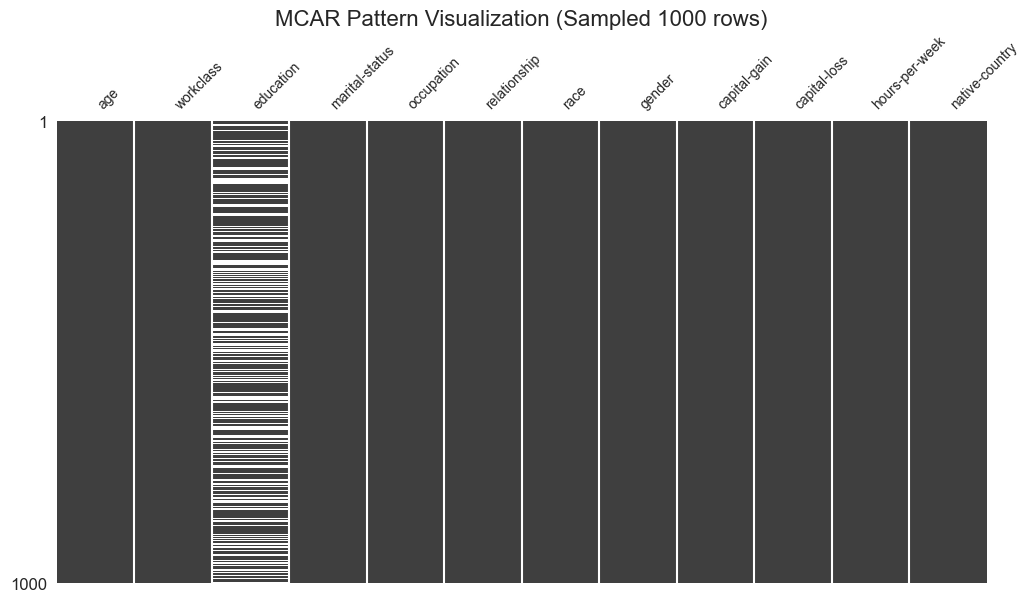

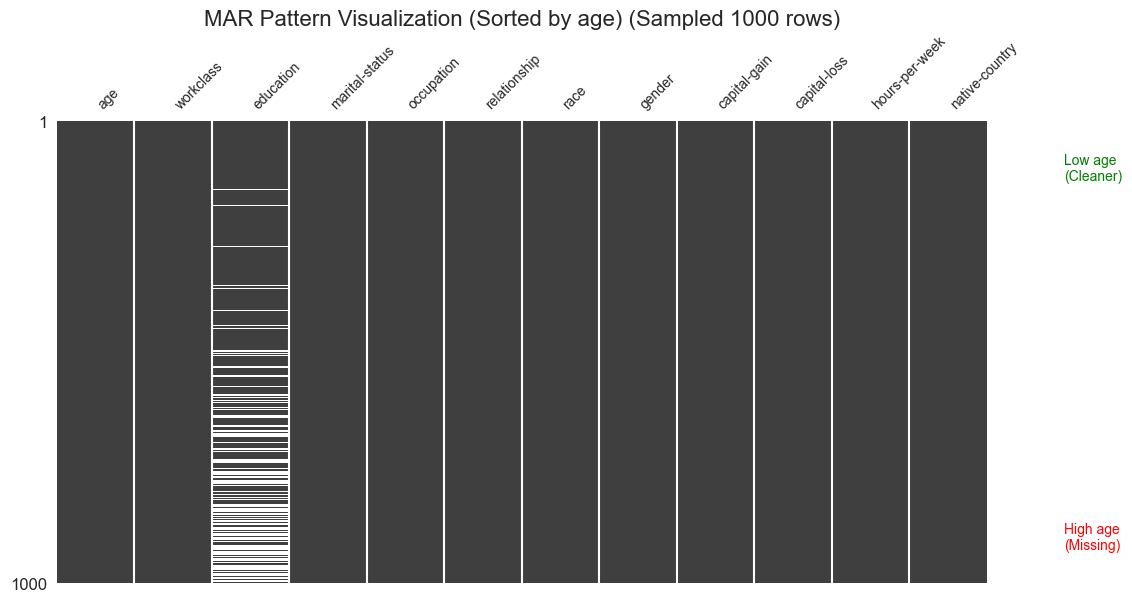

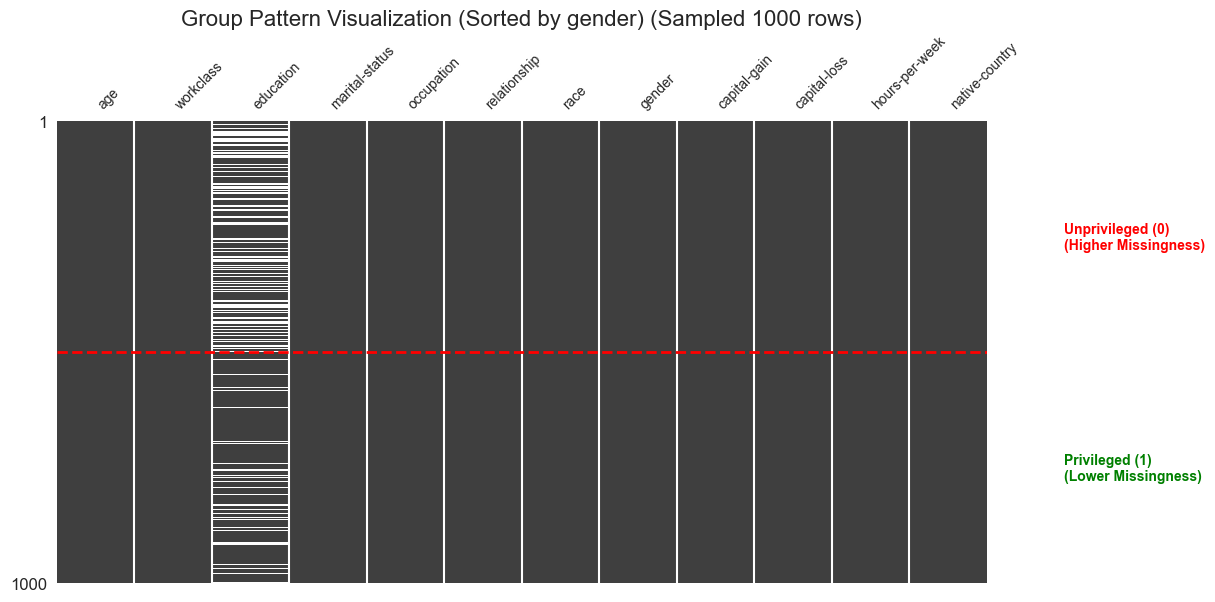

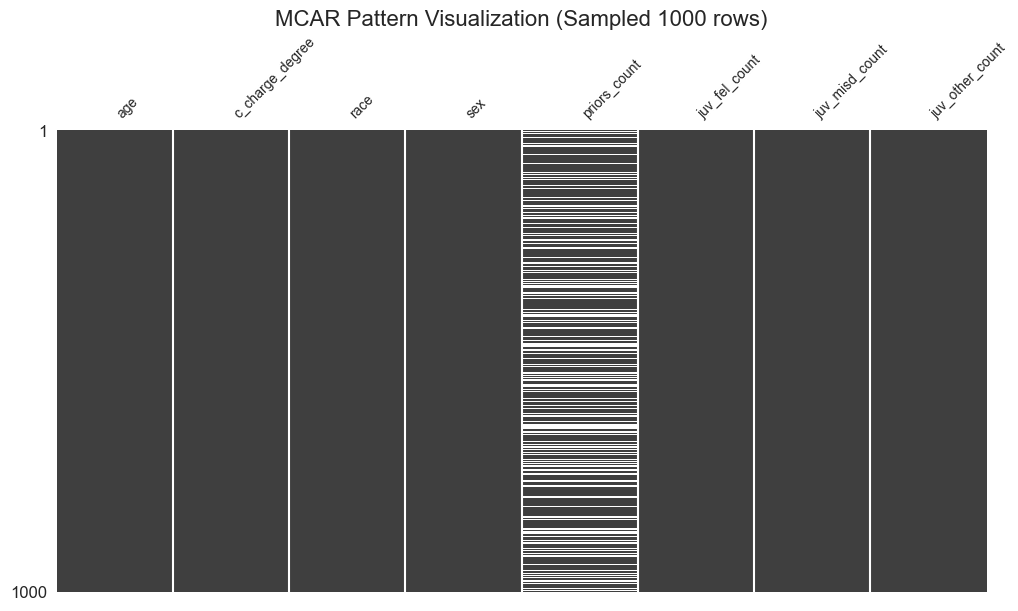

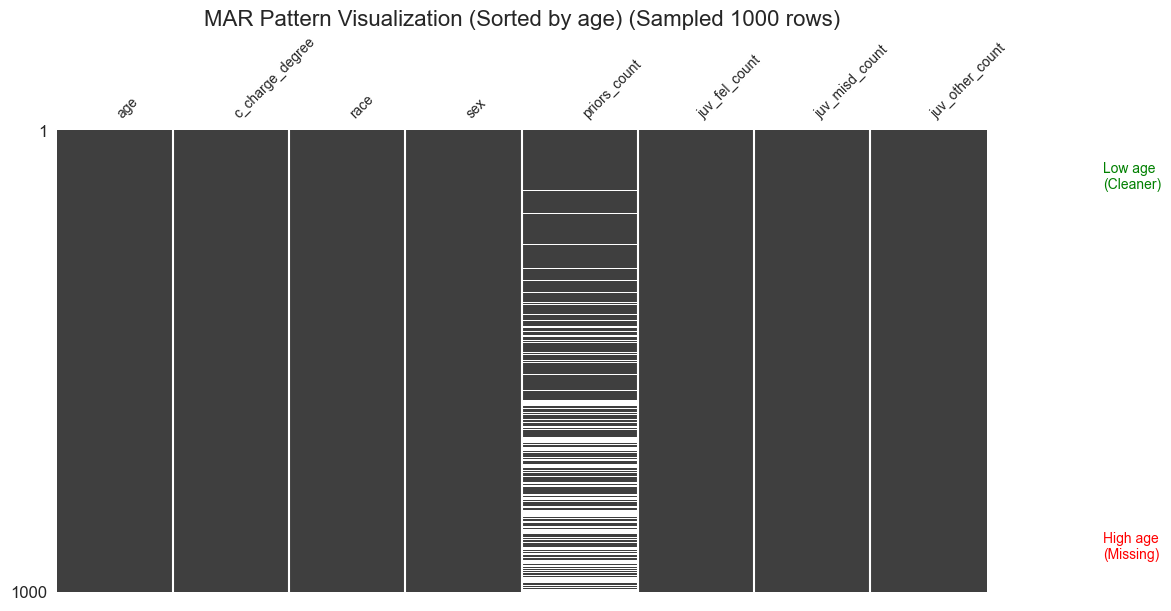

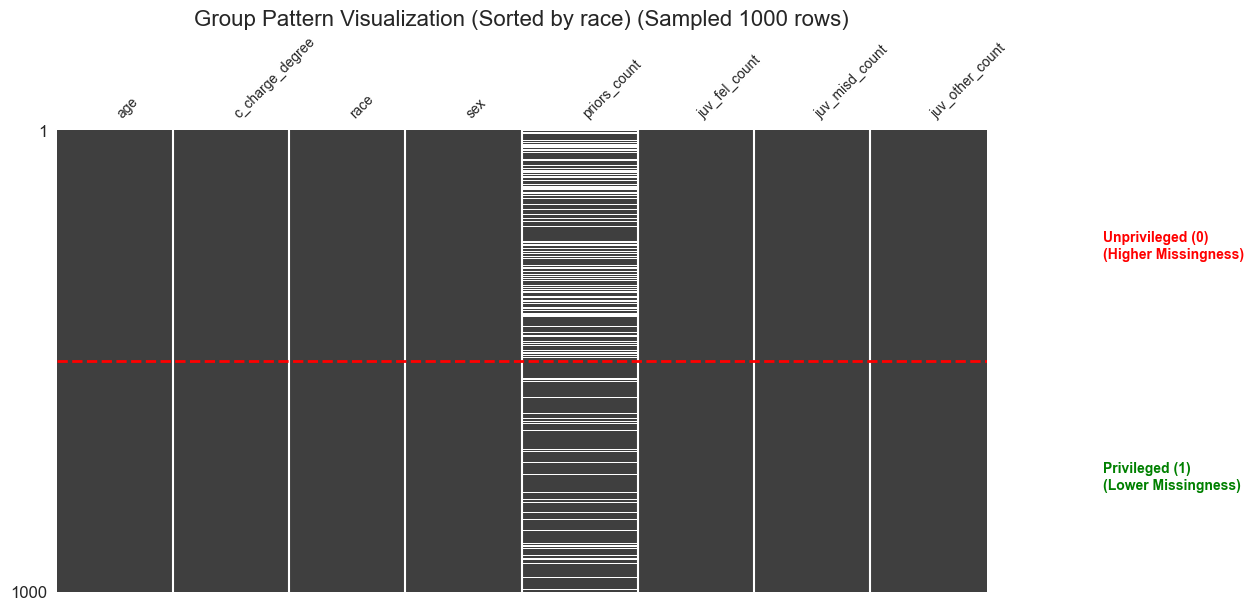

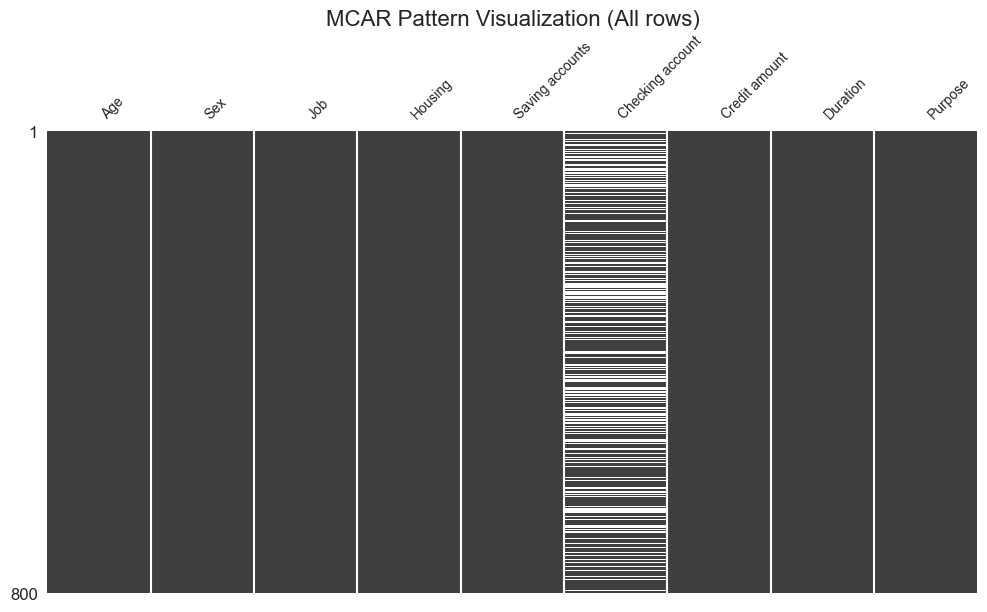

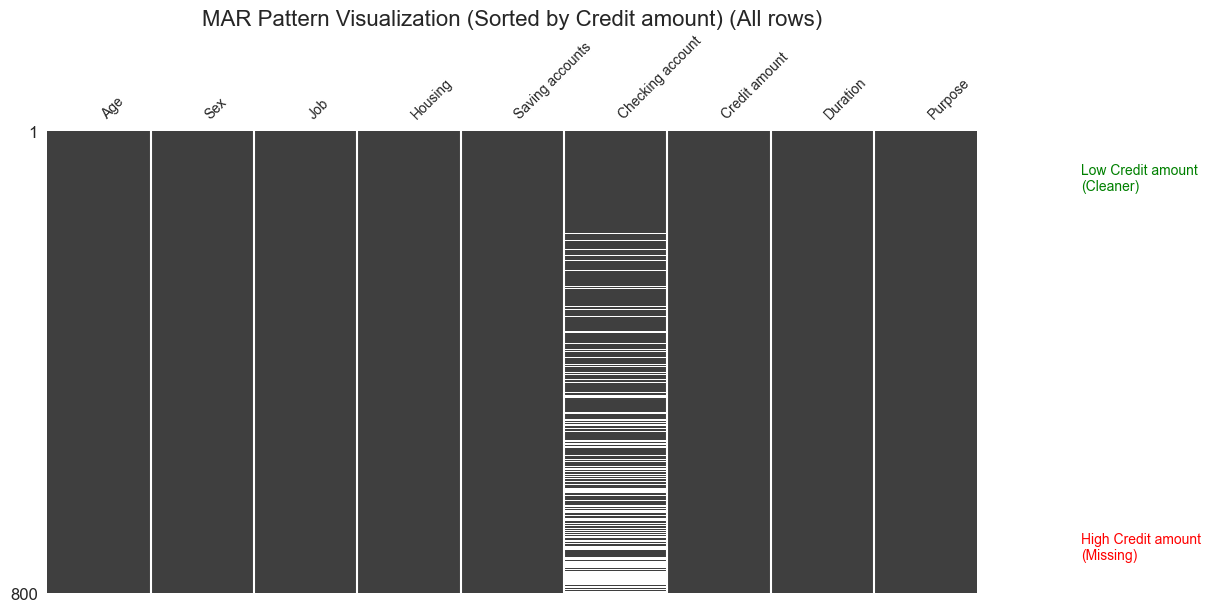

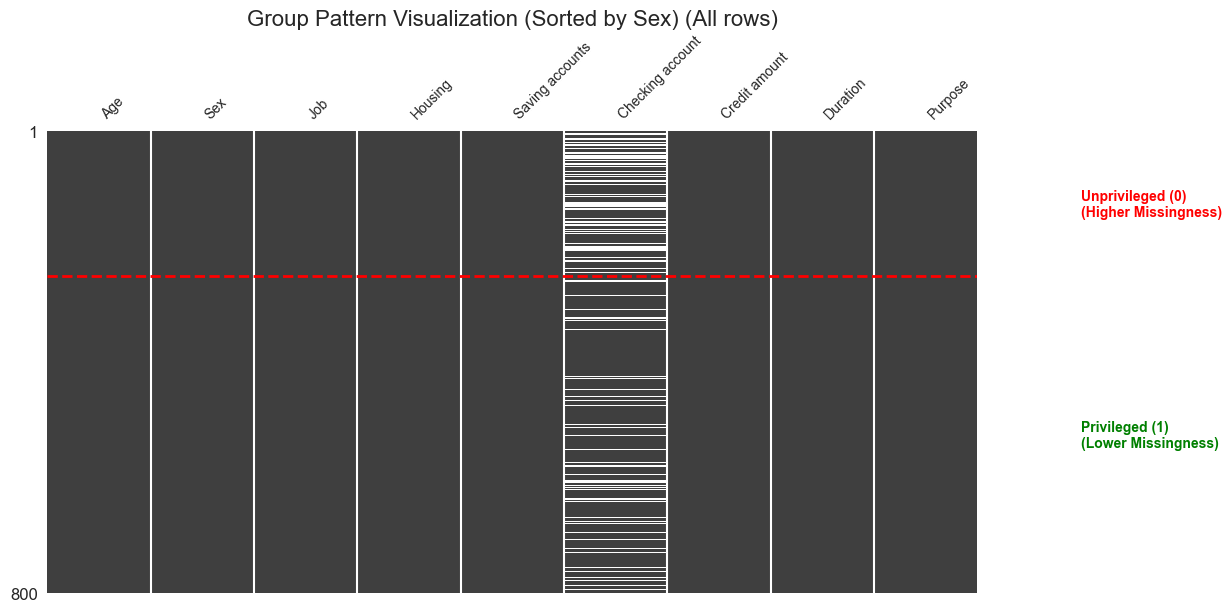

In [20]:
# 1. Adult Income
visualize_missing_patterns(missing_datasets["Adult"], configs["Adult"])

# 2. COMPAS
visualize_missing_patterns(missing_datasets["COMPAS"], configs["COMPAS"])

# 3. German Credit
visualize_missing_patterns(missing_datasets["German"], configs["German"])

# Imputation & Model Training Loop
This section is responsible for iterating through every combination of Dataset, Missingness Pattern and Imputation Method to evaluate how different imputation strategies impact model performance and fairness.
- The imputer is fitted exclusively on the training set to prevent leakage.
- Then, the test set is transformed based on the values the imputer learned from the training set.
- In the case of XGBoost, the No Imputation variant (XGBoost native handling) is also tested, where we just need to replace NaNs with a value like "Missing" so that the models treats missing data ans an informative feature.
- Since KNN and MICE are mathematical methods, the values they return are continuous. Because a categorical class (such as "relationship") is made of integer values, the output of these imputation methods is rounded to the nearest class (i.e., 1.6 gets rounded to 2 and 1.2 gets rounded to 1).
- After this preparation, the model is ready to be trained with the run_model function described previously.

In [21]:
# Imputation Methods
imputers = {
    "Original (No Imputation)": None,
    "Median": SimpleImputer(strategy="median"),
    "KNN": KNNImputer(n_neighbors=5),
    "MICE": IterativeImputer(max_iter=10, random_state=42)
}

for dataset_name, patterns_dict in missing_datasets.items():

    # Get categorical columns, sensitive column and target (of missingness) column
    sensitive_column, target_column = configs[dataset_name]["sensitive_column"], configs[dataset_name]["target"]
    if dataset_name == "Adult": categorical_columns = adult_categorical
    elif dataset_name == "COMPAS": categorical_columns = compas_categorical
    elif dataset_name == "German": categorical_columns = german_categorical

    print(f"\nCurrently Processing {dataset_name}:")

    for pattern_name, X_train_missing in patterns_dict.items():
        print(f"[Pattern: {pattern_name}]")

        for imp_name, imputer in imputers.items():
            # Retrieve the corresponding Test Set with the same missingness pattern
            X_test_missing = missing_test_sets[dataset_name][pattern_name].copy()

            if imputer is None:
                # No Imputation (XGBoost)
                X_train_imputed = X_train_missing.copy()
                X_test_imputed = X_test_missing.copy()

                if target_column in categorical_columns:
                    # Replace NaNs with "Missing" and convert to string to ensure compatibility
                    X_train_imputed[target_column] = X_train_imputed[target_column].fillna("Missing").astype(str)
                    X_test_imputed[target_column] = X_test_imputed[target_column].fillna("Missing").astype(str)

            else:
                # Fit Imputer on training set
                X_train_imputed_array = imputer.fit_transform(X_train_missing)
                X_train_imputed = pd.DataFrame(
                    X_train_imputed_array,
                    columns=X_train_missing.columns,
                    index=X_train_missing.index
                )

                # Transform test set using the values the imputer fitted on train
                X_test_imputed_array = imputer.transform(X_test_missing)
                X_test_imputed = pd.DataFrame(
                    X_test_imputed_array,
                    columns=X_test_missing.columns,
                    index=X_test_missing.index
                )

                # Round Categorical Columns
                if target_column in categorical_columns:
                    X_train_imputed[target_column] = X_train_imputed[target_column].round()
                    X_test_imputed[target_column] = X_test_imputed[target_column].round()

            # Train Models
            for model_name in ["logistic", "xgboost", "mlp"]:

                # Only XGBoost has native handling of NaNs, so skip other models
                if imp_name == "Original (No Imputation)" and model_name != "xgboost":
                    continue

                y_train = datasets_splits[dataset_name]["y_train"]
                y_test = datasets_splits[dataset_name]["y_test"]

                # Train the model
                metrics = run_model(
                    X_train_imputed,
                    X_test_imputed,
                    y_train,
                    y_test,
                    cat_columns=categorical_columns,
                    sensitive_column=sensitive_column,
                    experiment_name=f"{dataset_name} | {pattern_name} | {imp_name}",
                    model_type=model_name
                )

                metrics.update({
                    "Dataset": dataset_name,
                    "Missing Pattern": pattern_name,
                    "Imputation Method": imp_name,
                    "Model": model_name
                })

                results.append(metrics)

print("All models trained.")

# Print first 5 results just to check
final_df = pd.DataFrame(results)
print(final_df.head(5))


Currently Processing Adult:
[Pattern: MCAR_15]

 Training XGBOOST: Adult | MCAR_15 | Original (No Imputation)
Performance: Accuracy=0.8628 | F1=0.7023
Fairness:    DP Gap=0.1804 | EO Gap=0.0889

 Training LOGISTIC: Adult | MCAR_15 | Median
Performance: Accuracy=0.8434 | F1=0.6499
Fairness:    DP Gap=0.1808 | EO Gap=0.1372

 Training XGBOOST: Adult | MCAR_15 | Median
Performance: Accuracy=0.8640 | F1=0.7045
Fairness:    DP Gap=0.1758 | EO Gap=0.0899

 Training MLP: Adult | MCAR_15 | Median
Performance: Accuracy=0.8480 | F1=0.6702
Fairness:    DP Gap=0.1789 | EO Gap=0.0959

 Training LOGISTIC: Adult | MCAR_15 | KNN
Performance: Accuracy=0.8415 | F1=0.6509
Fairness:    DP Gap=0.1877 | EO Gap=0.1462

 Training XGBOOST: Adult | MCAR_15 | KNN
Performance: Accuracy=0.8630 | F1=0.7008
Fairness:    DP Gap=0.1794 | EO Gap=0.1050

 Training MLP: Adult | MCAR_15 | KNN
Performance: Accuracy=0.8463 | F1=0.6651
Fairness:    DP Gap=0.1859 | EO Gap=0.1362

 Training LOGISTIC: Adult | MCAR_15 | MICE
Pe

In [ ]:
# Save results to csv
final_df.to_csv("results_full.csv", index=False)

# Results Visualisation
This function reads the csv where all the results are stored and plots 9 graphs (3 for each dataset):
- Fairness vs Performance Trade-off: This plot aims to show how different models and imputation methods, on average across the multiple missingness patterns, behave in terms of F1 Score and Demographic Parity Score. The further right the model is, the higher the F1 score, and the further down the model is the lower the gap between groups (Demographic Parity Gap). A "perfect" model would be situated in the bottom-right corner.
- Impact of Imputation Methods on Fairness: This plot aims to show for each dataset, how each imputation method, on average across the multiple missingness patterns, affected the Demographic Parity Gap. For reference, the average Demographic Parity Gap achieved on the baseline models (where there was no missing data, therefore no imputation methods were performed) is shown as an horizontal line, to quickly distinguish methods that decreased or increased this gap.
- How does an Increase in MCAR Severity Impact Performance?: This plot aims to show, as MCAR severity increases (starting at 0% - baseline, increasing to 15% and achieving a maximum of 35%), if models can maintain close to their baseline performance (on average) or if they suffer heavily from missing data, thus decreasing their F1 score.

In [22]:
final_df = pd.read_csv("results_full.csv")

def plot_results_analysis(df):

    # Rename "None" Imputation in Baseline for "Baseline" for clarity
    df.loc[df["Missing Pattern"] == "Baseline", "Imputation Method"] = "Baseline"

    # Plot 1: Fairness vs Performance Tradeoff

    # Baseline points will be bigger compared to other models to be distinguishable
    df["Shape Size"] = df["Missing Pattern"].apply(lambda x: "Baseline" if x == "Baseline" else "Imputed")

    # Distinguish sizes between baseline and imputed models
    size_dict = {"Baseline": 400, "Imputed": 100}

    g = sns.relplot(
        data=df,
        x="F1",
        y="DP Gap",
        hue="Imputation Method",
        style="Model",
        size="Shape Size",
        sizes=size_dict,
        col="Dataset",
        kind="scatter",
        palette="viridis"
    )

    g.figure.suptitle("Fairness vs. Performance Trade-off", y=1.05, fontsize=20)
    g.set_titles("{col_name}")

    plt.show()

    # Plot 2: Impact of Imputation Methods on Fairness

    # Separate the dataframe into 2: Only with baseline results and without baseline results
    df_baseline = df[df["Imputation Method"] == "Baseline"]
    df_missing = df[df["Imputation Method"] != "Baseline"]

    g = sns.catplot(
        data=df_missing,
        x="Missing Pattern",
        y="DP Gap",
        hue="Imputation Method",
        col="Dataset",
        col_wrap=1,
        kind="bar",
        height=4,
        aspect=3,
        palette="rocket_r",
        edgecolor="black",
        errorbar=None,
        legend_out=True
    )

    g.figure.suptitle("Impact of Imputation on Fairness (Red Line = Baseline Fairness)", y=1.02, fontsize=20)

    # Map the axes to the correct dataset names
    axes = g.axes.flat
    dataset_names = df_missing["Dataset"].unique()

    for i, ax in enumerate(axes):
        # Get the dataset that is shown in this plot
        current_dataset = dataset_names[i]

        # Get the average Demographic Parity Gap across baseline plots for the current dataset
        baseline_val = df_baseline[df_baseline["Dataset"] == current_dataset]["DP Gap"].mean()

        # Draw the line for visual comparison
        if not pd.isna(baseline_val):
            ax.axhline(baseline_val, color="red", linestyle="--", linewidth=2.5, label="Baseline")

    plt.show()

    # Plot 3: MCAR Severity Impact on Perfromance

    # Filter only baseline results and MCAR patterns
    mcar_df = df[df["Missing Pattern"].isin(["Baseline", "MCAR_15", "MCAR_35"])].copy()
    pattern_map = {"Baseline": 0, "MCAR_15": 15, "MCAR_35": 35}
    mcar_df["Missing %"] = mcar_df["Missing Pattern"].map(pattern_map)

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=mcar_df,
        x="Missing %",
        y="F1",
        hue="Dataset",
        style="Model",
        markers=True,
        markersize=10,
        dashes=False,
        linewidth=2,
        palette="Set1",
        errorbar=None
    )
    plt.title("Performance Resilience: How datasets handle increased MCAR severity", fontsize=18)
    plt.xticks([0, 15, 35], ["Baseline (0%)", "MCAR 15%", "MCAR 35%"])
    plt.ylabel("F1 Score")
    plt.grid(True, which="major", linestyle="--", linewidth=0.5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

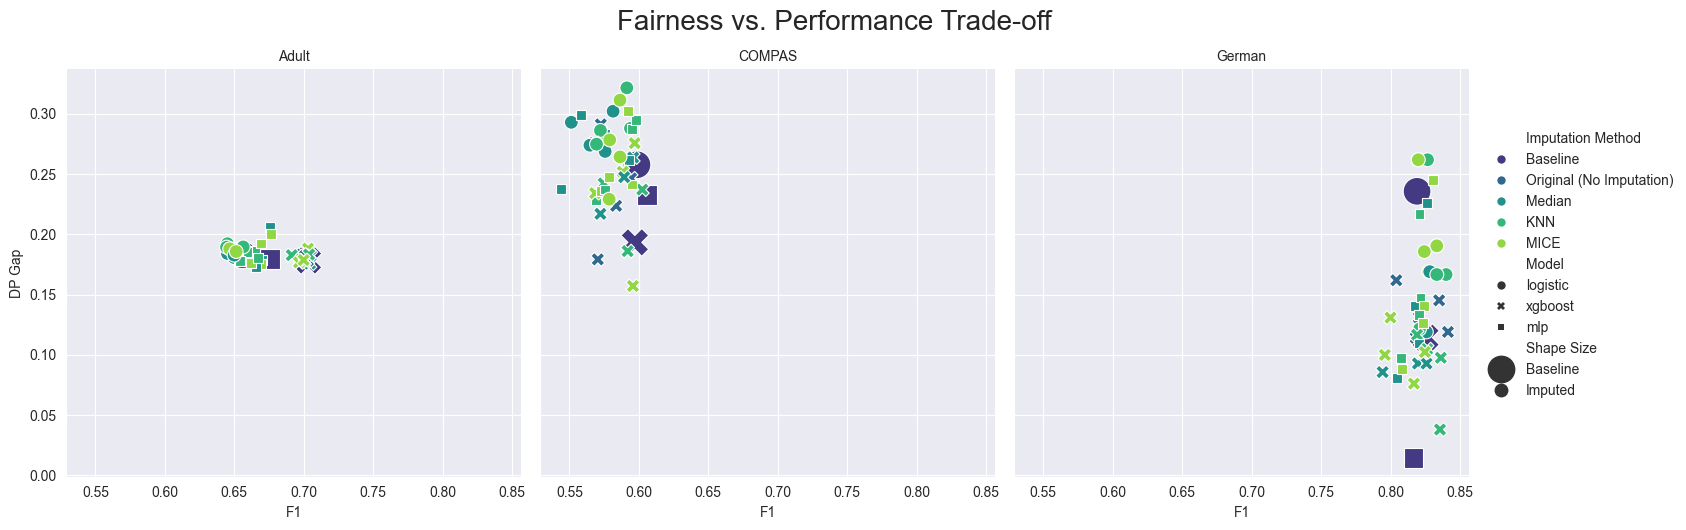

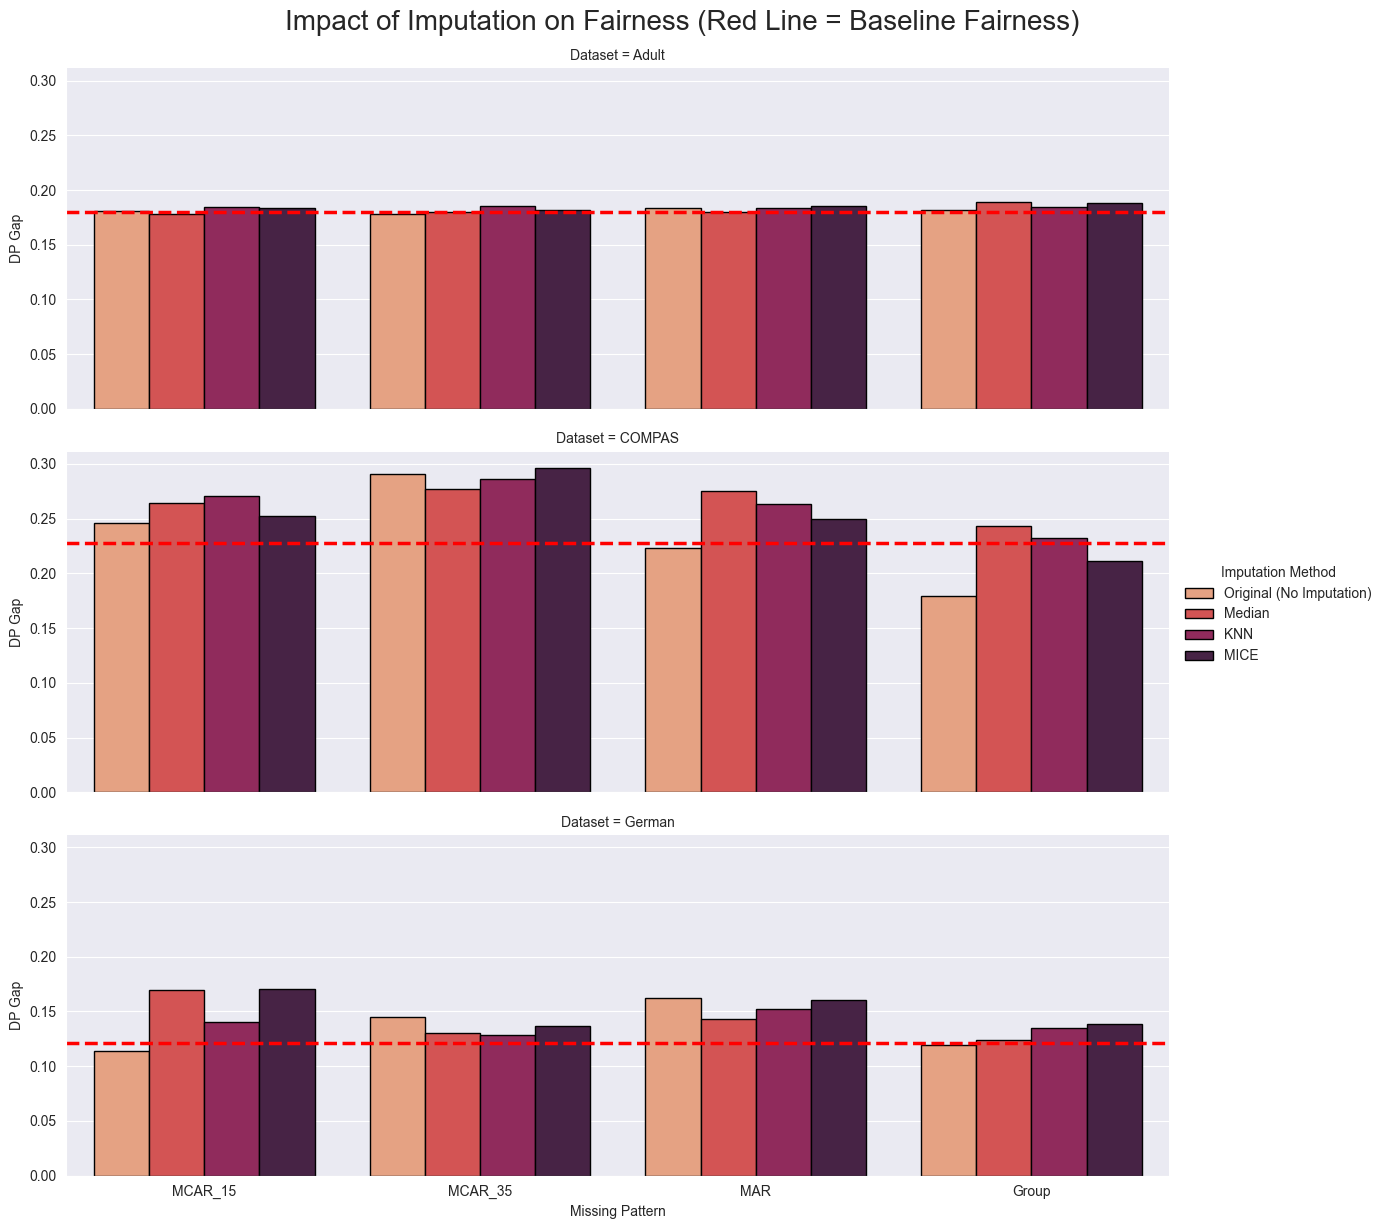

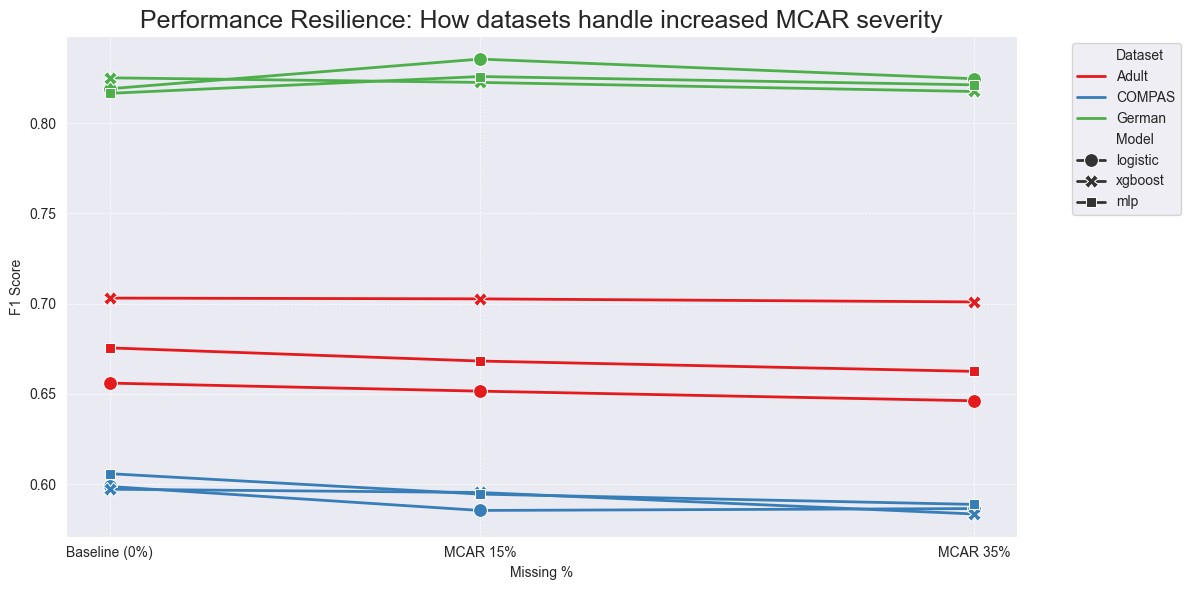

In [23]:
# Plot the results
plot_results_analysis(final_df)

# Get the "Best" Models
This function is designed to, for each dataset and missingness pattern, to get the best performing model. Every model is given a Model Score, which takes into account both F1 score and Demographic Parity Gap:

$$
\text{Model Score} = F1 - 1.5 \times \text{DP Gap}
$$

This scoring method gives one and a half times (1.5) more importance to the Fairness Metric, to benefit models that managed to improve fairness although their performance may have decreased slightly. The value 1.5 was chosen to give an edge to the Fairness Metric, while still being careful to not "destroy" the performance metric for a slight fairness improvement.

In the case multiple models have the same Model Score, the model with the lowest DP Gap, that is, the model that is fairer gets chosen.

In [24]:
def get_best_models(df, lambda_val=1.5):
    # Calculate Model Score based on the formula described above
    df_scored = df.copy()
    df_scored["Model Score"] = df_scored["F1"] - (lambda_val * df_scored["DP Gap"])

    best_models = []
    datasets = df_scored["Dataset"].unique()
    patterns = df_scored["Missing Pattern"].unique()

    for ds in datasets:
        print(f"Analysing {ds}")
        for pat in patterns:
            subset = df_scored[(df_scored["Dataset"] == ds) & (df_scored["Missing Pattern"] == pat)]

            # Find row with Max Model Score. In case of draws, chose the one with the lowest DP Gap
            best_run = subset.sort_values(by=["Model Score", "DP Gap"], ascending=[False, True]).iloc[0]

            # Only add imputation method if the current pattern isn't baseline (it would be redundant otherwise)
            imputation_method = str("+ " + best_run["Imputation Method"] + " ") if pat != "Baseline" else ""

            print(f"   [{pat}]: {best_run["Model"]} {imputation_method}(Score: {best_run["Model Score"]:.3f} | F1: {best_run["F1"]:.3f}, DP: {best_run["DP Gap"]:.3f})")

            best_models.append(best_run)

    return pd.DataFrame(best_models)

best_models = get_best_models(final_df)

Analysing Adult
   [Baseline]: xgboost (Score: 0.436 | F1: 0.703, DP: 0.178)
   [MCAR_15]: xgboost + Median (Score: 0.441 | F1: 0.704, DP: 0.176)
   [MCAR_35]: xgboost + Original (No Imputation) (Score: 0.436 | F1: 0.703, DP: 0.178)
   [MAR]: xgboost + MICE (Score: 0.432 | F1: 0.697, DP: 0.177)
   [Group]: xgboost + Median (Score: 0.433 | F1: 0.701, DP: 0.178)
Analysing COMPAS
   [Baseline]: xgboost (Score: 0.307 | F1: 0.597, DP: 0.193)
   [MCAR_15]: xgboost + KNN (Score: 0.247 | F1: 0.603, DP: 0.237)
   [MCAR_35]: xgboost + Median (Score: 0.218 | F1: 0.589, DP: 0.247)
   [MAR]: xgboost + Original (No Imputation) (Score: 0.248 | F1: 0.584, DP: 0.224)
   [Group]: xgboost + MICE (Score: 0.360 | F1: 0.596, DP: 0.157)
Analysing German
   [Baseline]: mlp (Score: 0.795 | F1: 0.817, DP: 0.014)
   [MCAR_15]: xgboost + KNN (Score: 0.778 | F1: 0.836, DP: 0.038)
   [MCAR_35]: logistic + Median (Score: 0.647 | F1: 0.826, DP: 0.119)
   [MAR]: xgboost + KNN (Score: 0.690 | F1: 0.836, DP: 0.098)
   [

# Removing Trivial Models
As described previously, the Selection Rate is a way of checking if a model actually learned meaningful patterns. This checks if there are any trivial models and, if so remove them. A model that was considered to be a "best model" (MLP baseline for the German Dataset) was actually a trivial model, that basically guessed the majority class (1) for close to all test cases, getting an accuracy close to the actual positive class percentage (69% accuracy vs 70% of positive cases in the target variable), and it achieved a Selection Rate of 0.99 which proves this claim.

After removing these models, the plots and best models are recalculated.

In [25]:
# A model is trivial if it predicts (almost) the same class for all test cases (either 0 or 1)
# A threshold of 10% for each side was defined as the limit between a trivial and a non-trivial model
valid_mask = (final_df["Selection Rate"] > 0.10) & (final_df["Selection Rate"] < 0.90)


df_clean = final_df[valid_mask].copy()
n_dropped = len(final_df) - len(df_clean)
print(f"Removed {n_dropped} out of {len(final_df)} models")

Removed 4 out of 129 models


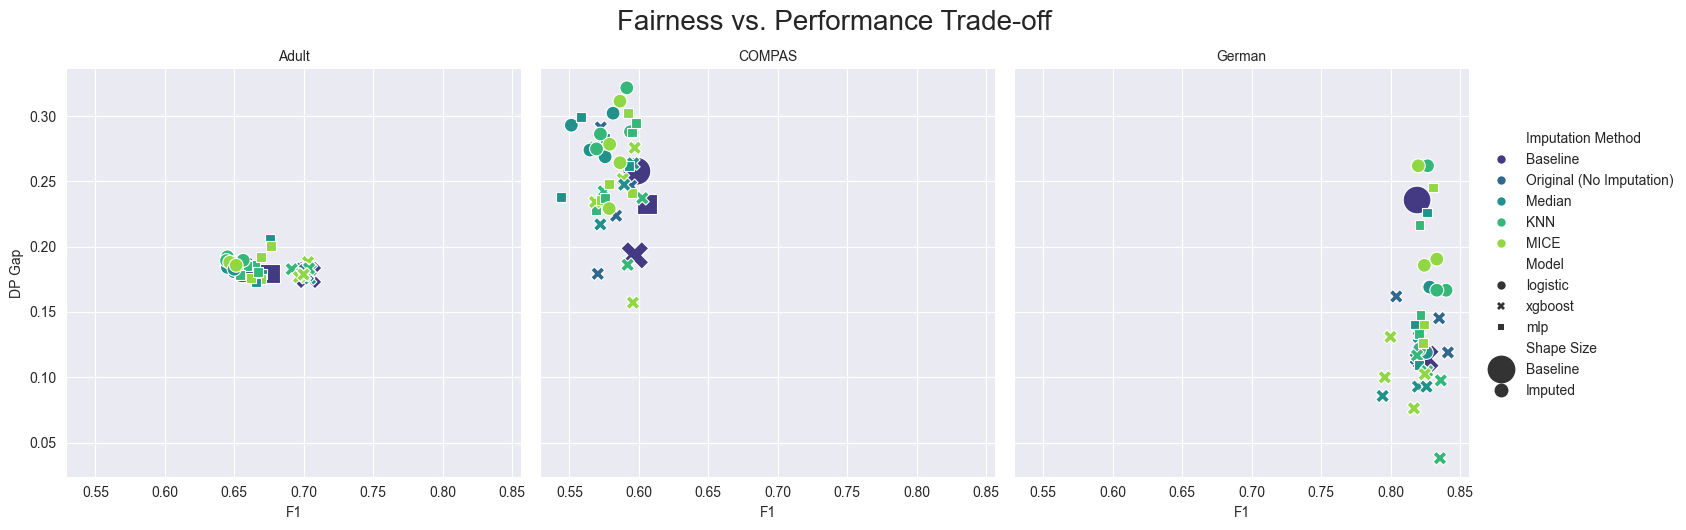

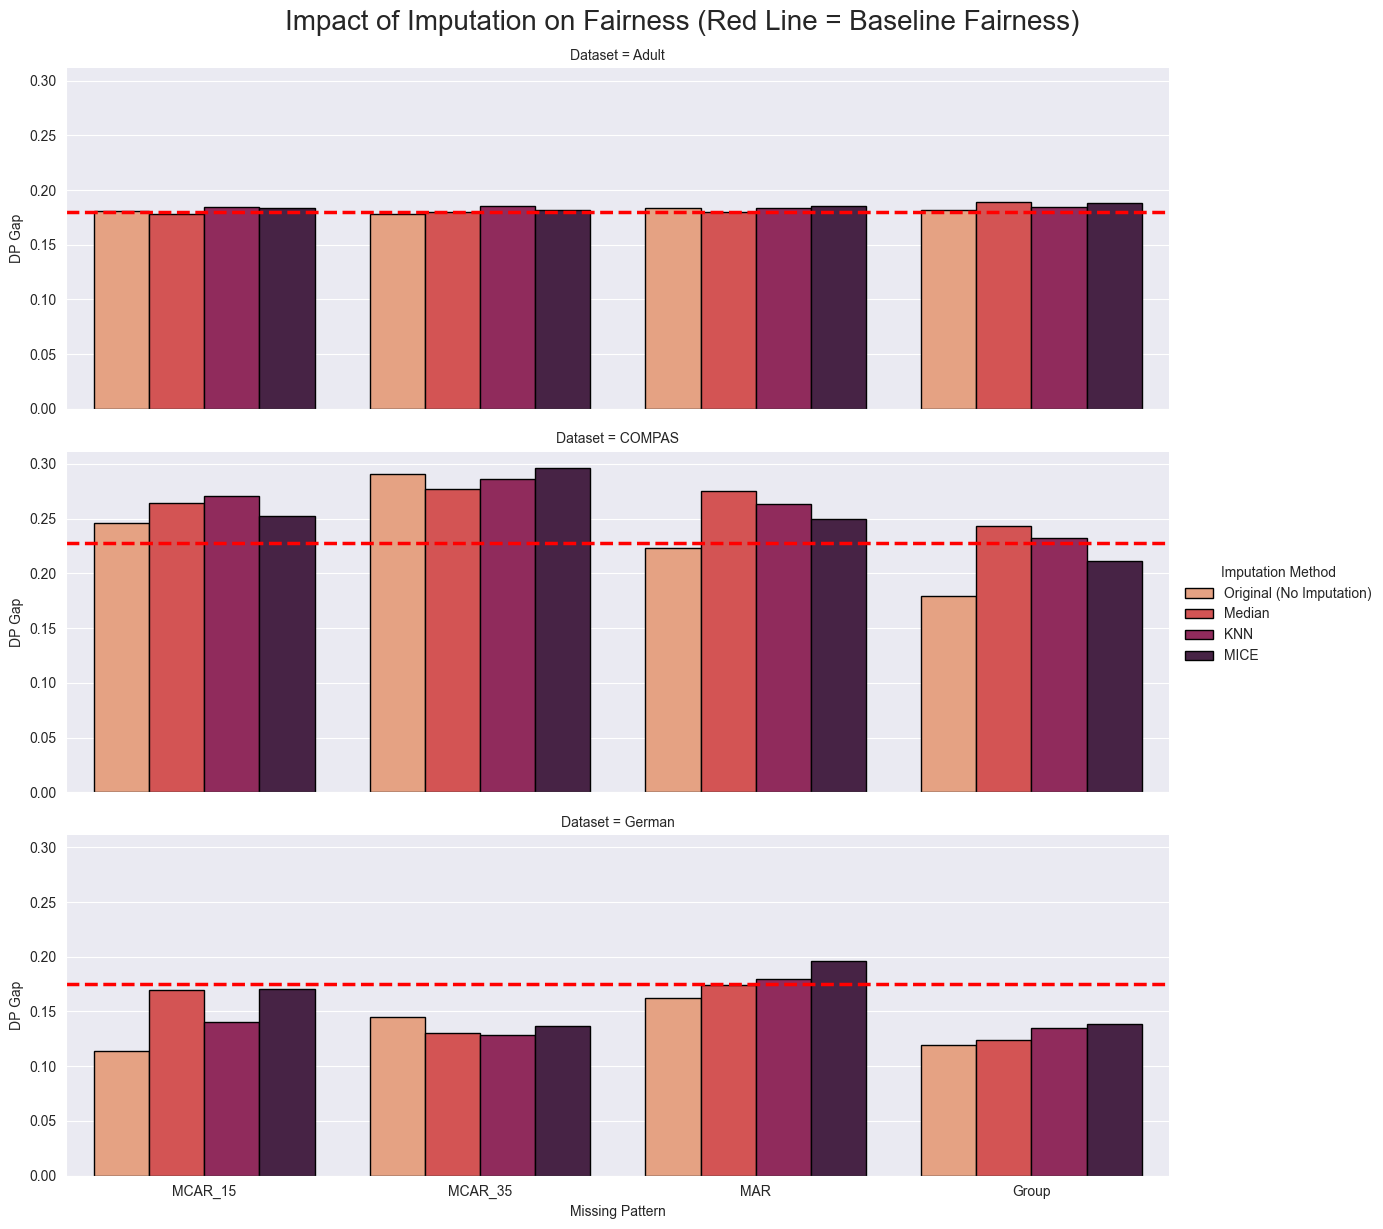

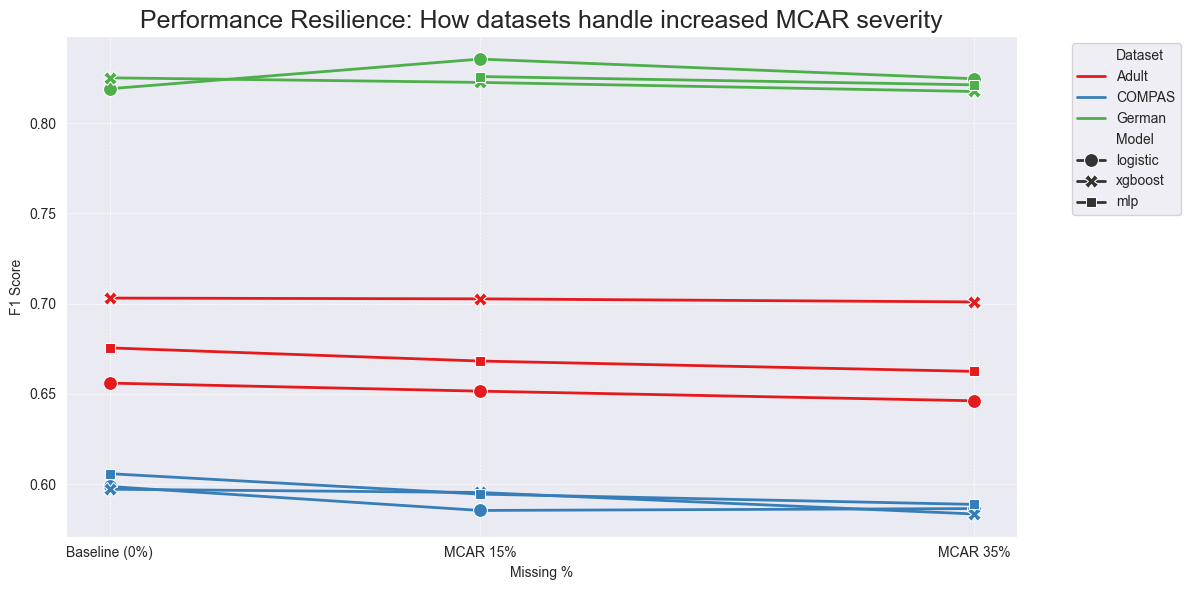

In [26]:
plot_results_analysis(df_clean)

In [27]:
actual_best_models = get_best_models(df_clean)

Analysing Adult
   [Baseline]: xgboost (Score: 0.436 | F1: 0.703, DP: 0.178)
   [MCAR_15]: xgboost + Median (Score: 0.441 | F1: 0.704, DP: 0.176)
   [MCAR_35]: xgboost + Original (No Imputation) (Score: 0.436 | F1: 0.703, DP: 0.178)
   [MAR]: xgboost + MICE (Score: 0.432 | F1: 0.697, DP: 0.177)
   [Group]: xgboost + Median (Score: 0.433 | F1: 0.701, DP: 0.178)
Analysing COMPAS
   [Baseline]: xgboost (Score: 0.307 | F1: 0.597, DP: 0.193)
   [MCAR_15]: xgboost + KNN (Score: 0.247 | F1: 0.603, DP: 0.237)
   [MCAR_35]: xgboost + Median (Score: 0.218 | F1: 0.589, DP: 0.247)
   [MAR]: xgboost + Original (No Imputation) (Score: 0.248 | F1: 0.584, DP: 0.224)
   [Group]: xgboost + MICE (Score: 0.360 | F1: 0.596, DP: 0.157)
Analysing German
   [Baseline]: xgboost (Score: 0.654 | F1: 0.825, DP: 0.114)
   [MCAR_15]: xgboost + KNN (Score: 0.778 | F1: 0.836, DP: 0.038)
   [MCAR_35]: logistic + Median (Score: 0.647 | F1: 0.826, DP: 0.119)
   [MAR]: xgboost + KNN (Score: 0.690 | F1: 0.836, DP: 0.098)


# Appendix
This section aims to validate the results across 50 different random seeds to ensure robustness. The general process follows the same process fone in this notebook.

In [ ]:
# Define the seeds to be trained (50, selected this way to ensure reproducibility)
SEEDS = list(range(42, 92))

# Store the datasets to be used
dataset_map = {
    "Adult": df_adult_encoded,
    "COMPAS": df_compas_encoded,
    "German": df_german_encoded
}

# Define the imputers to be used
imputers = {
    "Original (No Imputation)": None,
    "Median": SimpleImputer(strategy="median"),
    "KNN": KNNImputer(n_neighbors=5),
    "MICE": IterativeImputer(max_iter=10) # random_state will be set in loop
}

multiple_validation_results = []

for seed in SEEDS:
    print(f"Running models for seed {seed}")

    # Split datasets for this seed
    current_splits = {}
    for ds_name, df_obj in dataset_map.items():
        # Create a stratified train-test split
        X_train, X_test, y_train, y_test = stratified_train_test_split(
            df_obj, target_column="target", dataset_name=ds_name, random_state=seed
        )

        current_splits[ds_name] = {
            "X_train": X_train, "X_test": X_test,
            "y_train": y_train, "y_test": y_test
        }

    # Iterate through datasets and configurations (sensitive column and mar_cause)
    for dataset_name, params in configs.items():
        if dataset_name == "Adult":
            categorical_columns, sensitive_column, target = adult_categorical, "gender", "education"
        elif dataset_name == "COMPAS":
            categorical_columns, sensitive_column, target = compas_categorical, "race", "priors_count"
        elif dataset_name == "German":
            categorical_columns, sensitive_column, target = german_categorical, "Sex", "Checking account"

        # Retrieve Seed Data
        X_train_clean = current_splits[dataset_name]["X_train"]
        X_test_clean = current_splits[dataset_name]["X_test"]
        y_train = current_splits[dataset_name]["y_train"]
        y_test = current_splits[dataset_name]["y_test"]

        patterns = ["Baseline", "MCAR_15", "MCAR_35", "MAR", "Group"]
        # Iterate through missingness patterns
        for pattern in patterns:
            # Generate Missing Data for this seed
            if pattern == "Baseline":
                # Baseline has no missing data, therefore also has no imputation
                X_train_miss = X_train_clean.copy()
                X_test_miss = X_test_clean.copy()

                current_imputers = {"Baseline" : "Baseline"}
            else:
                # MCAR_15 and MCAR_35 have the missing rate shown on their name, MAR and Group-Based have a missing rate of 25%
                rate = 0.15 if "15" in pattern else (0.35 if "35" in pattern else 0.25)
                # Get the missing data pattern (for MCAR_15 and MCAR_35, the pattern is the same, so strip what comes before "_")
                pat_type = pattern.split("_")[0]

                # Inject missing data on train set
                X_train_miss = introduce_missingness(
                    X_train_clean, target, pat_type, rate,
                    params["sensitive_column"], params.get("mar_cause"), random_state=seed
                )
                # Inject missing data on test set
                X_test_miss = introduce_missingness(
                    X_test_clean, target, pat_type, rate,
                    params["sensitive_column"], params.get("mar_cause"), random_state=seed
                )

                # Use the imputers defined initially
                current_imputers = imputers

            # Iterate through the imputers
            for imp_name, imp_obj in current_imputers.items():

                # Set the seed (same as current) for MICE
                if imp_name == "MICE":
                    imputer = IterativeImputer(max_iter=10, random_state=seed)
                # XGBoost native handling
                elif imp_obj is None:
                    imputer = None
                else:
                    imputer = imp_obj

                # Baseline has no imputation, so "imputed" train and test sest are the same as the original
                if imputer == "Baseline":
                    imp_name = "None"
                    X_train_imp = X_train_miss.copy()
                    X_test_imp = X_test_miss.copy()

                # XGBoost native handling, similar handling as "Imputation & Model Training Loop" section of the notebook
                elif imputer is None:
                    X_train_imp = X_train_miss.copy()
                    X_test_imp = X_test_miss.copy()

                    if target in categorical_columns:
                        X_train_imp[target] = X_train_imp[target].fillna("Missing").astype(str)
                        X_test_imp[target] = X_test_imp[target].fillna("Missing").astype(str)
                else:
                    try:
                        # Fit on training set
                        X_train_imp_vals = imputer.fit_transform(X_train_miss)
                        X_train_imp = pd.DataFrame(X_train_imp_vals, columns=X_train_miss.columns, index=X_train_miss.index)

                        # Transform on test set
                        X_test_imp_vals = imputer.transform(X_test_miss)
                        X_test_imp = pd.DataFrame(X_test_imp_vals, columns=X_test_miss.columns, index=X_test_miss.index)

                        # Round values in categorical columns to closest integer
                        if target in categorical_columns:
                            X_train_imp[target] = X_train_imp[target].round()
                            X_test_imp[target] = X_test_imp[target].round()
                    except ValueError as e:
                        print(f"Skipping {imp_name} on {dataset_name} seed {seed} due to error: {e}")
                        continue

                # Train the models
                for model_name in ["logistic", "xgboost", "mlp"]:

                    # Only XGBoost can be trained with no imputation for missing data
                    if imputer is None and model_name != "xgboost":
                        continue

                    # Train model
                    metrics = run_model(
                        X_train_imp,
                        X_test_imp,
                        y_train,
                        y_test,
                        categorical_columns,
                        sensitive_column,
                        f"{dataset_name}_{pattern}_{imp_name}",
                        model_type=model_name,
                        random_state=seed
                    )

                    # Add Metadata
                    metrics.update({
                        "Dataset": dataset_name,
                        "Missing Pattern": pattern,
                        "Imputation Method": imp_name,
                        "Model": model_name,
                        "Seed": seed
                    })

                    multiple_validation_results.append(metrics)

# Save results to dataframe
df_results = pd.DataFrame(multiple_validation_results)

# Filter out trivial models (same threshold as before)
df_results = df_results[(df_results["Selection Rate"] > 0.10) & (df_results["Selection Rate"] < 0.90)].copy()

# Calculate Model Score (as described previously)
df_results["Model Score"] = df_results["F1"] - (1.5 * df_results["DP Gap"])

# Store raw results
df_results.to_csv("multiple_validation_results_raw.csv")

# For each dataset, Missingness Pattern, Imputation Method and Model calculate the average and standard deviation of F1, DP Gap and Model Score across all seeds
df_results = df_results.groupby(["Dataset", "Missing Pattern", "Imputation Method", "Model"])[
    ["F1", "DP Gap", "Model Score"]
].agg(["mean", "std"])

df_results.columns = [f"{col[0]} ({col[1]})" for col in df_results.columns]

df_results = df_results.reset_index()

# Store final results to a new csv
df_results.to_csv("multiple_validation_results.csv", index=False)

# T-Test to check if more complex imputers significantly outperform simpler ones
This function aims to understand if the more complex imputation methods (KNN, MICE) significantly outperform the simpler Median imputation (or no Imputation for XGBoost) in terms of F1 Score and DP Gap across different datasets and missingness patterns, to understand if the added complexity is justified.

In [28]:
def run_automatic_significance(raw_csv_path="stability_results_raw.csv"):
    df = pd.read_csv(raw_csv_path)

    # Exclude "Baseline" pattern
    scenarios = df[df["Missing Pattern"] != "Baseline"][["Dataset", "Missing Pattern"]].drop_duplicates().values

    results = []

    for ds, pat in scenarios:
        # Filter relevant data
        subset = df[(df["Dataset"] == ds) & (df["Missing Pattern"] == pat)]

        # Get the highest scoring model
        leaderboard = subset.groupby(["Model", "Imputation Method"])["Model Score"].mean().reset_index()
        winner_row = leaderboard.loc[leaderboard["Model Score"].idxmax()]

        winner_model = winner_row["Model"]
        winner_imp = winner_row["Imputation Method"]

        # Get baseline score (for XGBoost is native handling, otherwise is median)
        if winner_model == "xgboost":
            baseline_imp = "Original (No Imputation)"
        else:
            baseline_imp = "Median"

        # Initialize Result Dictionary
        result = {
            "Dataset": ds,
            "Pattern": pat,
            "Winner_Model": winner_model,
            "Winner_Imputation": winner_imp,
            "Baseline_Imputation": baseline_imp,
            "Mean_Diff": 0.0,
            "P_Value": None,
            "Significant": False,
            "Comment": ""
        }

        # If the winner is the baseline imputation method, no t-test is needed
        if winner_imp == baseline_imp:
            print(f"[{ds} | {pat}] Winner is Baseline ({baseline_imp}).")
            result["Comment"] = "Winner is Baseline (No test needed)"
            results.append(result)
            continue

        # 5. CASE B: Complex Imputation Won -> Run Stats

        # Get Paired Seeds
        winner_runs = subset[(subset["Model"] == winner_model) & (subset["Imputation Method"] == winner_imp)].set_index("Seed")["Model Score"]
        baseline_runs = subset[(subset["Model"] == winner_model) & (subset["Imputation Method"] == baseline_imp)].set_index("Seed")["Model Score"]

        # Align
        aligned = pd.concat([winner_runs, baseline_runs], axis=1, join="inner")
        aligned.columns = ["Winner", "Baseline"]

        # Run T-Test
        t_stat, p_val = ttest_rel(aligned["Winner"], aligned["Baseline"])
        mean_diff = aligned["Winner"].mean() - aligned["Baseline"].mean()

        # Print the results of the test (at the end, "Significant" is printed if the p-value is lesser than 0.05, i.e., the complex imputation gave significant improvements compared to the baseline
        sig_str = "Significant" if p_val < 0.05 else ""
        print(f"[{ds} | {pat}] Winner ({winner_imp}) vs {baseline_imp}: Δ={mean_diff:.3f}, p={p_val:.4f} {sig_str}")

        result["Mean_Diff"] = mean_diff
        result["P_Value"] = p_val
        result["Significant"] = p_val < 0.05
        result["Comment"] = "Significant" if p_val < 0.05 else "Not Significant"

        results.append(result)

    return pd.DataFrame(results)

In [29]:
df_ttest = run_automatic_significance(raw_csv_path="multiple_validation_results_raw.csv")
df_ttest.to_csv("t_test_results.csv", index=False)

[Adult | MCAR_15] Winner is Baseline (Original (No Imputation)).
[Adult | MCAR_35] Winner is Baseline (Original (No Imputation)).
[Adult | MAR] Winner (Median) vs Original (No Imputation): Δ=0.000, p=0.8980 
[Adult | Group] Winner is Baseline (Original (No Imputation)).
[COMPAS | MCAR_15] Winner (KNN) vs Original (No Imputation): Δ=0.004, p=0.4915 
[COMPAS | MCAR_35] Winner (MICE) vs Original (No Imputation): Δ=0.019, p=0.0048 Significant
[COMPAS | MAR] Winner (KNN) vs Original (No Imputation): Δ=0.000, p=0.9493 
[COMPAS | Group] Winner (MICE) vs Original (No Imputation): Δ=0.007, p=0.1527 
[German | MCAR_15] Winner (KNN) vs Original (No Imputation): Δ=0.010, p=0.3838 
[German | MCAR_35] Winner is Baseline (Original (No Imputation)).
[German | MAR] Winner (KNN) vs Original (No Imputation): Δ=0.014, p=0.2502 
[German | Group] Winner is Baseline (Original (No Imputation)).


# Deep Dive on MCAR (35%) on COMPAS Dataset
We saw, on the base study performed on random_state=42, that Median imputation outperformed other methods on the COMPAS dataset with MCAR (35%) missingness pattern, but after the multiple seed validation, MICE imputation emerged as the winner (p=0.016706 < 0.05).

In [30]:
seed = 42
ds_name = "COMPAS"
target_col_miss = "priors_count"

# Get Data
df_dive = df_compas_encoded.copy()
X_train, X_test, y_train, y_test = stratified_train_test_split(
    df_dive, target_column="target", dataset_name=ds_name, random_state=seed
)

# Inject MCAR 35%
X_train_miss = introduce_missingness(X_train, target_col_miss, "MCAR", 0.35, "race", random_state=seed)

# Calculate RMSE for both Median and MICE reconstructions
median = SimpleImputer(strategy="median")
mice = IterativeImputer(max_iter=10, random_state=seed)

X_median = pd.DataFrame(median.fit_transform(X_train_miss), columns=X_train.columns, index=X_train.index)
X_mice = pd.DataFrame(mice.fit_transform(X_train_miss), columns=X_train.columns, index=X_train.index)

def get_rmse(X_true, X_imp, X_raw, col):
    mask = X_raw[col].isna()
    truth = X_true.loc[mask, col]
    guess = X_imp.loc[mask, col]
    return math.sqrt(mean_squared_error(truth, guess))

rmse_med = get_rmse(X_train, X_median, X_train_miss, target_col_miss)
rmse_mice = get_rmse(X_train, X_mice, X_train_miss, target_col_miss)

print(f"Column: {target_col_miss}")
print(f"Median RMSE: {rmse_med:.4f} (Baseline)")
print(f"MICE RMSE:   {rmse_mice:.4f} (Global Winner)")
print(f"Percentual gain in fidelity: {((rmse_med - rmse_mice)/rmse_med)*100:.1f}%")

if rmse_mice < rmse_med:
    print("MICE reconstructed the data more accurately, explaining its long-term stability.")
else:
    print("MICE failed to reconstruct better on this seed (explains why it lost here).")

Stratified splitting for COMPAS
Train Shape: (4222, 8) | Test Shape: (1056, 8)
Train Target Counts: [2236 1986] ([52.96 47.04])
Test Target Counts: [559 497] ([52.94 47.06])
Column: priors_count
Median RMSE: 5.1738 (Baseline)
MICE RMSE:   4.3870 (Global Winner)
Percentual gain in fidelity: 15.2%
MICE reconstructed the data more accurately, explaining its long-term stability.
